# **Trabajo práctico integrador. Aprendizaje de Máquina 1.**

Estudiantes:

*   Gustavo Julián Rivas
*   Myrna Lorena Degano
*   Santiago José Olaciregui
*   Fabricio Lopretto

### Objetivo

Evaluar diversas características de tumores de mama para predecir si el tumor es maligno o benigno.


### Introducción:
En este trabajo se usó una base de datos con diferentes atributos asociados a tumores mamarios. A partir de técnicas de procesamiento imagenes utilizando un clasificador inductivo basado en programación lineal, se creó un sistema de alta precisión para el diagnóstico de tumores de mama (Wolberg y otros, 1992).

A partir de muestras tomadas mediante jeringa y con una interfaz interactiva, se inicializaron modelos de contorno activos, conocidos como *snakes*, cerca de los límites de un conjunto de núcleos celulares.

Las *snakes* personalizadas se deforman con la forma exacta de los núcleos. Esto permite un análisis preciso y automatizado del tamaño, la forma y la textura del núcleo. Se calculan diez características para cada núcleo, definiendo su el valor medio, el valor más grande (o peor) y la desviación estándar de cada característica para cada tumor en particular. Por ejemplo, el radio medio se calcula como la media de la distancia del centro de la célula hasta cada punto del perímetro.

#### Import de librerías a utilizar

In [4]:
!pip install seaborn
!pip install ucimlrepo

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.datasets import load_breast_cancer
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import RFE
from ucimlrepo import fetch_ucirepo 
  


## 1. Obtención de datos

### Conjunto de datos

El set de Datos utilizado lleva el nombre de *Conjunto de datos Breast Cancer Wisconsin (Diagnostic)* (Wolberg y otros, 1995).

Contiene características/atributos obtenidas a partir de imágenes digitales de células mamarias, como el radio, la textura, perímetro, y otras características. Se lo puede encontrar en el siguiente link:

Diagnostic Wisconsin Breast Cancer Database.

https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

Las características se calculan a partir de una imágenes de una masa mamaria. Describen características de los núcleos celulares presentes en la imagen. Algunas de las imágenes se pueden encontrar en http://www.cs.wisc.edu/~street/images/

Créditos

William Wolberg | Olvi Mangasarian | Nick Street | W. Street
Creative Commons Attribution 4.0 International (CC BY 4.0) license.
https://creativecommons.org/licenses/by/4.0/legalcode

In [6]:
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 

### Metadata

In [7]:
print(breast_cancer_wisconsin_diagnostic.metadata) 

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'published_in': 'Electronic imaging', 'year': 1993, 'url': 'https://www.semanticscholar.org/paper/53

### Variables

In [8]:
# Cargar el dataset desde sklearn.datasets 
data = load_breast_cancer()

# Convertirlo en dataframe para explorar los datos
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

In [9]:
dtypes = df.dtypes
inte_columns = dtypes[dtypes == 'int32'].count() + dtypes[dtypes == 'int64'].count()
real_columns = dtypes[dtypes == 'float32'].count() + dtypes[dtypes == 'float64'].count()
cate_columns = dtypes[dtypes == 'object'].count()
print(f"Cant. campo entero: {inte_columns} \nCant. campo categórico: {cate_columns} \nCant. campo real: {real_columns}")

Cant. campo entero: 1 
Cant. campo categórico: 0 
Cant. campo real: 30


In [10]:
# Muestra los tipos de datos de los atributos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

Observaciones: El Data Frame tiene los tipos de datos unificados. Las características reales son todas del tipo 'float64' y el objetivo es 'int32'.

Además, tiene todas variables numéricas continuas porque corresponden a medidas del tumor. Ampliando a lo mencionado, se puede discriminar las variables para un determinado tumor por valor medio, desvío estándar y peor valor.

Características relacionadas con valores promedio:

* mean radius: Radio medio de las células del tumor.
* mean texture: Textura media del tumor, que mide la variabilidad de la intensidad del píxel en la imagen del tumor.
* mean perimeter: Perímetro medio del tumor.
* mean area: Área media del tumor.
* mean smoothness: Suavidad media del contorno del tumor.
* mean compactness: Compactación media del tumor, que mide la relación entre el área y el perímetro.
* mean concavity: Concavidad media del tumor, que indica la severidad de las indentaciones en el contorno del tumor.
* mean concave points: Puntos concavos medios en el contorno del tumor.
* mean symmetry: Simetría media del tumor, que mide la simetría de la forma del tumor.
* mean fractal dimension: Dimensión fractal media del tumor, que mide la complejidad del contorno del tumor.

Características relacionadas con la desviación estándar (medidas de variabilidad):

* radius error: Error estándar del radio.
* texture error: Error estándar de la textura.
* perimeter error: Error estándar del perímetro.
* area error: Error estándar del área.
* smoothness error: Error estándar de la suavidad.
* compactness error: Error estándar de la compactación.
* concavity error: Error estándar de la concavidad.
* concave points error: Error estándar de los puntos concavos.
* symmetry error: Error estándar de la simetría.
* fractal dimension error: Error estándar de la dimensión fractal.

Medidas más extremas observadas para cada característica (peor valor):

* worst radius: Radio máximo observado del tumor.
* worst texture: Textura máxima observada del tumor.
* worst perimeter: Perímetro máximo observado del tumor.
* worst area: Área máxima observada del tumor.
* worst smoothness: Suavidad máxima observada del tumor.
* worst compactness: Compactación máxima observada del tumor.
* worst concavity: Concavidad máxima observada del tumor.
* worst concave points: Puntos concavos máximos observados en el tumor.
* worst symmetry: Simetría máxima observada del tumor.
* worst fractal dimension: Dimensión fractal máxima observada del tumor.

## 2. Preparación de datos

### Chequeo de duplicados

In [11]:
# Verifica si hay registros duplicados en todo el DataFrame
def duplicados(df):
  """
  Verifica si el DataFrame ingresado tiene
  registros duplicados.

  :param:
  :df: DataFrame con los atributos.
  """
  hay_duplicados = df.duplicated().any()

  if hay_duplicados:
      print("El DataFrame tiene registros duplicados.")
  else:
      print("El DataFrame no tiene registros duplicados.")

In [12]:
duplicados(df)

El DataFrame no tiene registros duplicados.


### Chequeo de Faltantes

In [13]:
def datos_faltantes(df):
  """
  Permite conocer la cantidad de datos faltantes de
  cada campo del Data Frame de ingresado.

  :param:
  :df: DataFrame con los atributos.
  """
  campos = df.columns.tolist()
  for campo in campos:
    # Hay registros con datos faltantes?
    print(f"Cantidad de datos faltantes de {campo}: {df[campo].isna().sum()}")

In [14]:
datos_faltantes(df)

Cantidad de datos faltantes de mean radius: 0
Cantidad de datos faltantes de mean texture: 0
Cantidad de datos faltantes de mean perimeter: 0
Cantidad de datos faltantes de mean area: 0
Cantidad de datos faltantes de mean smoothness: 0
Cantidad de datos faltantes de mean compactness: 0
Cantidad de datos faltantes de mean concavity: 0
Cantidad de datos faltantes de mean concave points: 0
Cantidad de datos faltantes de mean symmetry: 0
Cantidad de datos faltantes de mean fractal dimension: 0
Cantidad de datos faltantes de radius error: 0
Cantidad de datos faltantes de texture error: 0
Cantidad de datos faltantes de perimeter error: 0
Cantidad de datos faltantes de area error: 0
Cantidad de datos faltantes de smoothness error: 0
Cantidad de datos faltantes de compactness error: 0
Cantidad de datos faltantes de concavity error: 0
Cantidad de datos faltantes de concave points error: 0
Cantidad de datos faltantes de symmetry error: 0
Cantidad de datos faltantes de fractal dimension error: 0


También se buscó si las características reales tienen valores numéricos que se asocian a faltantes, para ello se busca el rango de cada una de ellas.

In [15]:
# Busca el rango de cada caracteristica
rango = df.describe().loc[['min', 'max']]

# Se agrega el indice 'range' y  se completa la fila creada con la diferencia entre 'max' y 'min'.
rango.loc['range'] = rango.loc['max'] - rango.loc['min']

# se presenta el rango de cada campo
rango.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
min          6.981          9.71           43.79      143.5          0.05263   
max         28.110         39.28          188.50     2501.0          0.16340   
range       21.129         29.57          144.71     2357.5          0.11077   

       mean compactness  mean concavity  mean concave points  mean symmetry  \
min             0.01938          0.0000               0.0000          0.106   
max             0.34540          0.4268               0.2012          0.304   
range           0.32602          0.4268               0.2012          0.198   

       mean fractal dimension  ...  worst texture  worst perimeter  \
min                   0.04996  ...          12.02            50.41   
max                   0.09744  ...          49.54           251.20   
range                 0.04748  ...          37.52           200.79   

       worst area  worst smoothness  worst compactness  worst concavity  \
min         185.2           0.07117            0.02729            0.000   
max        4254.0           0.22260            1.05800            1.252   
range      4068.8           0.15143            1.03071            1.252   

       worst concave points  worst symmetry  worst fractal dimension  target  
min                   0.000          0.1565                  0.05504     0.0  
max                   0.291          0.6638                  0.20750     1.0  
range                 0.291          0.5073                  0.15246     1.0  

[3 rows x 31 columns]

Observaciones: En todos los casos los valores mínimos y máximos resultan consistentes (por ejemplo no existen valores -99 para indicar faltantes de radio). Por otro lado, se vio que la magnitud del rango entre las diferentes características varía, lo que invita a realizar un escalamiento de las mismas.

Además, se busca si existe alguna observación que haya sido completada con algún caracter especial ('-' por ejemplo) para indicar faltantes.

In [16]:
# Verifica si existe alguna fila con todos los valores como '-'
hay_fila_con_solo_guiones = df.apply(lambda row: all(cell == '-' for cell in row), axis=1).any()

print(f"¿Existe alguna observación completada solo con '-': {hay_fila_con_solo_guiones}")

¿Existe alguna observación completada solo con '-': False


Observaciones: No existen valores faltantes en este dataset.

### Separar entrenamiento y test

In [17]:
X = df.drop('target', axis=1)
y = df['target']

In [18]:
X.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0                 0.07871  ...         25.38          17.33           184.60   
1                 0.05667  ...         24.99          23.41           158.80   
2                 0.05999  ...         23.57          25.53           152.50   
3                 0.09744  ...         14.91          26.50            98.87   
4                 0.05883  ...         22.54          16.67           152.20   

   worst area  worst smoothness  worst compactness  worst concavity  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   worst concave points  worst symmetry  worst fractal dimension  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 30 columns]

In [19]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

In [20]:
# 70-30
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42)

### Escalamiento de datos

In [21]:
# StandardScaler   -> promedio=0, desviacion estandar=1                       (cada feature)
# MinMaxScaler     -> escala valores de 0 a 1, (o rango pasado por parametro) (cada feature)
# RobustScaler     -> escala siendo robusto a outliers                        (cada feature)
# Normalizer       -> modifica los datos para que tengan norma=1              (cada fila) puede servir para calculos de ciertas distancias entre las isntancias como la distancia coseno

scalers = [
    StandardScaler(), 
    MinMaxScaler(),  
    RobustScaler(),  
    Normalizer(),  
]

In [22]:
# Dataset escalado
scaled_df = {}

for scaler in scalers:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Transformar en DataFrames
    df_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
    df_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)
    df_train_scaled['target'] = y_train.reset_index(drop=True)
    df_test_scaled['target'] = y_test.reset_index(drop=True)

    scaled_df[str(scaler)[:-2]] = [df_train_scaled, df_test_scaled]

    print(f"Datos de Entrenamiento Escalados con {scaler}:")
    print(df_train_scaled.head())
    
    print(f"\nDatos de Prueba Escalados con {scaler}:")
    print(df_test_scaled.head())


Datos de Entrenamiento Escalados con StandardScaler():
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0    -0.123490     -0.296801       -0.170507  -0.208616        -1.201680   
1    -0.228268     -0.657951       -0.253775  -0.296503        -1.804637   
2     0.145534     -1.230564        0.245833  -0.010242         0.519184   
3    -0.358532     -0.672207       -0.400937  -0.400014        -1.203862   
4    -0.157472      0.967224       -0.208843  -0.241538        -0.254695   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0         -0.773170       -0.762312            -0.933241      -1.229949   
1         -0.587616       -0.091985            -0.542684      -1.419985   
2          1.570006        0.732320             0.386583       1.054201   
3         -0.970650       -0.634704            -0.654992       0.096572   
4         -0.700630       -0.750349            -0.637469      -0.518248   

   mean fractal dimension  ...  worst

## 3. Exploración de datos

### Visualizar las primeras filas.

In [23]:
df.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   worst symmetry  worst fractal dimension  target  
0          0.4601                  0.11890       0  
1          0.2750                  0.08902       0  
2          0.3613                  0.08758       0  
3          0.6638                  0.17300       0  
4          0.2364                  0.07678       0  

[5 rows x 31 columns]

### Realizar un resumen de 5 números.

In [24]:
# Resumen estadistico de las columnas numericas
df.describe()

mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       mean symmetry  mean fractal dimension  ...  worst texture  \
count     569.000000              569.000000  ...     569.000000   
mean        0.181162                0.062798  ...      25.677223   
std         0.027414                0.007060  ...       6.146258   
min         0.106000                0.049960  ...      12.020000   
25%         0.161900                0.057700  ...      21.080000   
50%         0.179200                0.061540  ...      25.410000   
75%         0.195700                0.066120  ...      29.720000   
max         0.304000                0.097440  ...      49.540000   

       worst perimeter   worst area  worst smoothness  worst compactness  \
count       569.000000   569.000000        569.000000         569.000000   
mean        107.261213   880.583128          0.132369           0.254265   
std          33.602542   569.356993          0.022832           0.157336   
min          50.410000   185.200000          0.071170           0.027290   
25%          84.110000   515.300000          0.116600           0.147200   
50%          97.660000   686.500000          0.131300           0.211900   
75%         125.400000  1084.000000          0.146000           0.339100   
max         251.200000  4254.000000          0.222600           1.058000   

       worst concavity  worst concave points  worst symmetry  \
count       569.000000            569.000000      569.000000   
mean          0.272188              0.114606        0.290076   
std           0.208624              0.065732        0.061867   
min           0.000000              0.000000        0.156500   
25%           0.114500              0.064930        0.250400   
50%           0.226700              0.099930        0.282200   
75%           0.382900              0.161400        0.317900   
max           1.252000              0.291000        0.663800   

       worst fractal dimension      target  
count               569.000000  569.000000  
mean                  0.083946    0.627417  
std                   0.018061    0.483918  
min                   0.055040    0.000000  
25%                   0.071460    0.000000  
50%                   0.080040    1.000000  
75%                   0.092080    1.000000  
max                   0.207500    1.000000  

[8 rows x 31 columns]

In [25]:
for scaler_name, dfs in scaled_df.items():
    print(scaler_name)
    for d in dfs:
        description = df.describe()
        #print(description.T)

StandardScaler
MinMaxScaler
RobustScaler
Normalizer


In [26]:
# Diccionario traduccion de atributos
features_esn = {
    'mean radius' : 'Radio medio',              
    'mean texture' : 'Textura media',              
    'mean perimeter' : 'Perímetro medio',
    'mean area' : 'Área media',
    'mean smoothness' : 'Suavidad media',            
    'mean compactness' : 'Compactación media',
    'mean concavity' :  'Concavidad media',           
    'mean concave points' : 'Puntos cóncavos medios',
    'mean symmetry' : 'Simetría media',            
    'mean fractal dimension' : 'Dimensión fractal media',    
    'radius error' : 'Error estándar del radio',              
    'texture error' : 'Error estándar de la textura',             
    'perimeter error' : 'Error estándar del perímetro',            
    'area error' : 'Error estándar del área',                 
    'smoothness error' : 'Error estándar de la suavidad',           
    'compactness error' : 'Error estándar de la compatación',          
    'concavity error' : 'Error estándar de la concavidad',           
    'concave points error' : 'Error estándar de los puntos cóncavos',      
    'symmetry error' : 'Error estándar de la simetría',            
    'fractal dimension error' : 'Error estándar de la dimensión fractal',  
    'worst radius' : 'Peor radio',              
    'worst texture' : 'Peor textura',             
    'worst perimeter' : 'Peor perímetro',
    'worst area' : 'Peor área',
    'worst smoothness' : 'Peor suavidad',          
    'worst compactness' : 'Peor compactación',         
    'worst concavity' : 'Peor concavidad',      
    'worst concave points' : 'Peor número de puntos cóncavos',      
    'worst symmetry' : 'Peor simetría',            
    'worst fractal dimension' : 'Peor dimensión fractal'
}

In [27]:
print(df['target'].unique())

[0 1]


El target se compone de una variable categórica numérica entera.
Clasificación binaria (0-1)

In [28]:
# Nombres de las clases
target_names = data.target_names

# Codificacion de la clase
target_values = set(data.target)

# Crea un diccionario para mapear valores a nombres de clases
target_description = {i: name for i, name in enumerate(target_names)}

print(target_description)


{0: 'malignant', 1: 'benign'}


0 - Representa un tumor maligno.

1 - Representa tumor benigno.

In [29]:
target_esn = {
    0: 'Maligno',
    1: 'Benigno'
}

### Distribución de los datos

In [30]:
# Columnas numericas
num_columns = df.select_dtypes(include=['float64']).columns

In [31]:
palette = {
    0: '#ff9999',  # Rojo
    1: '#99ff99'   # Verde
}

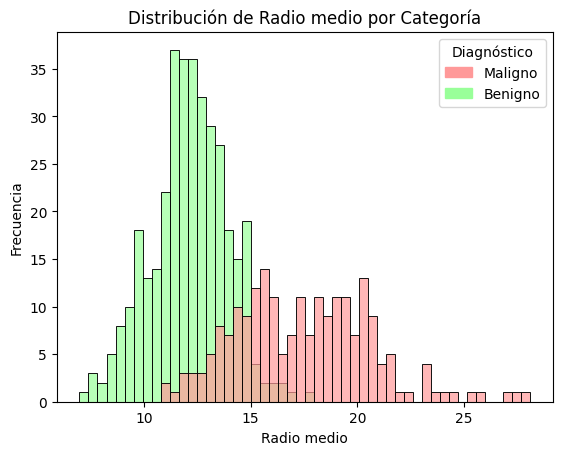

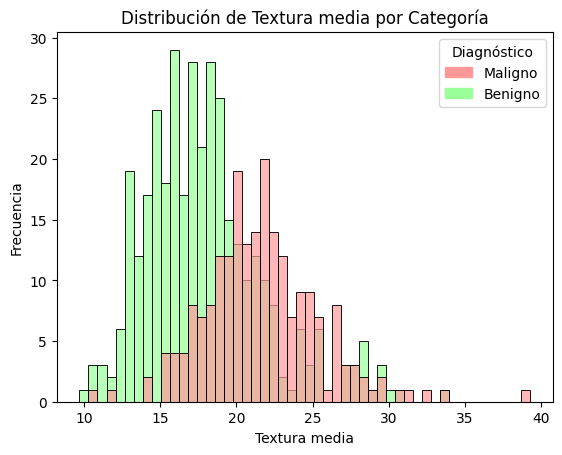

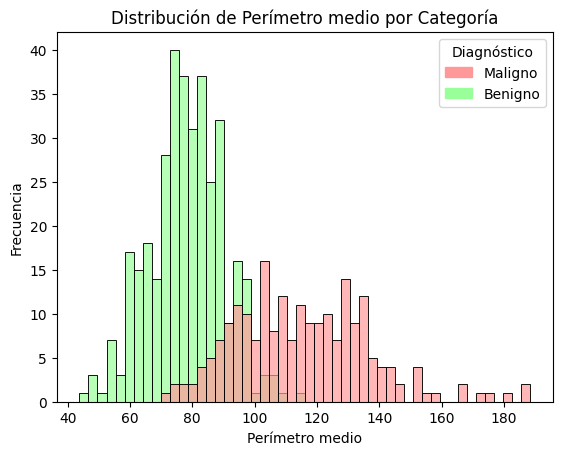

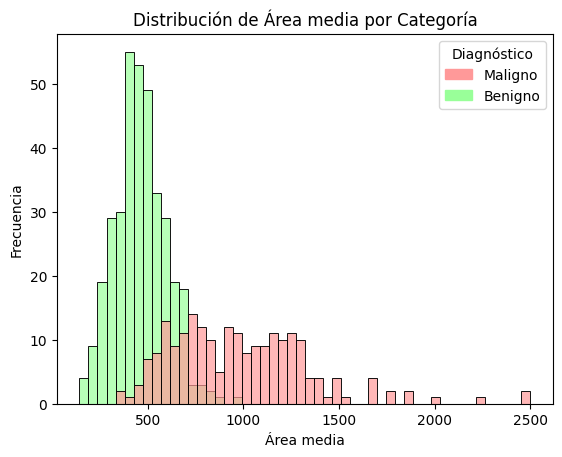

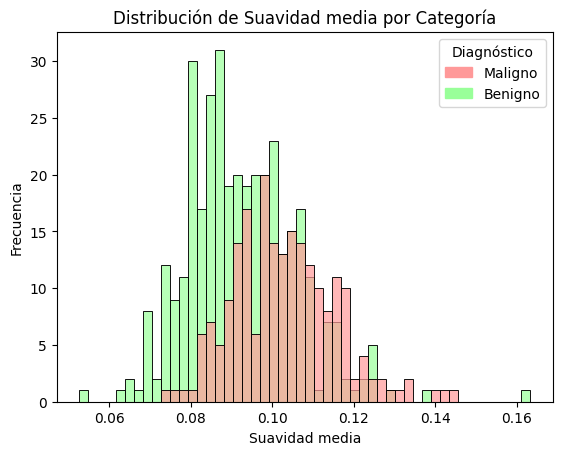

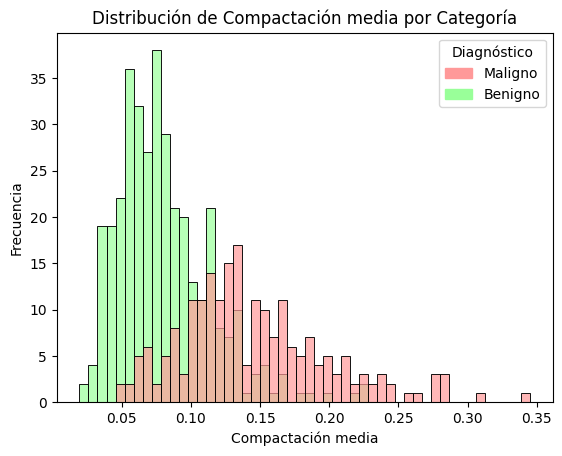

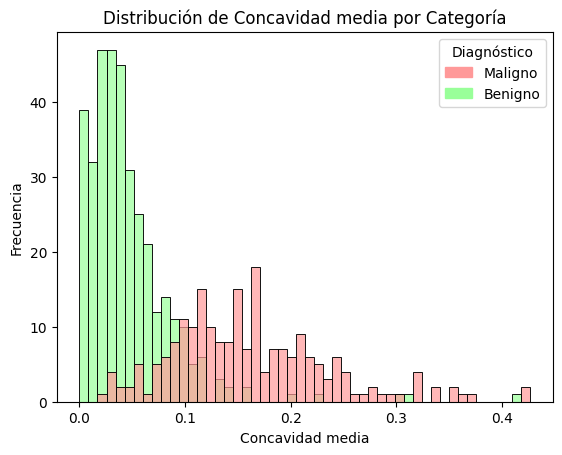

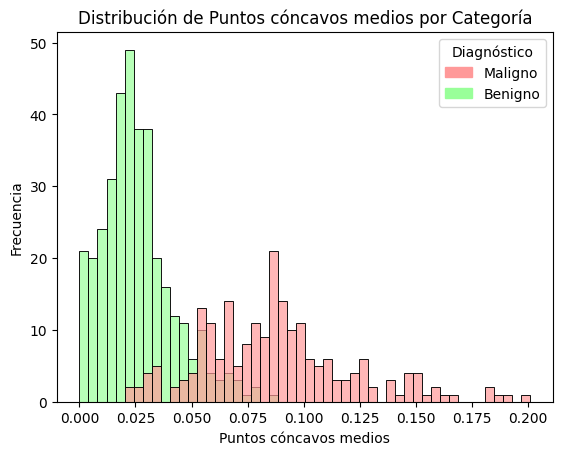

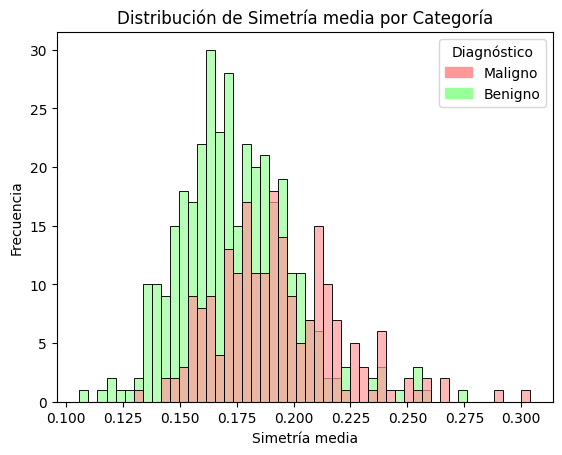

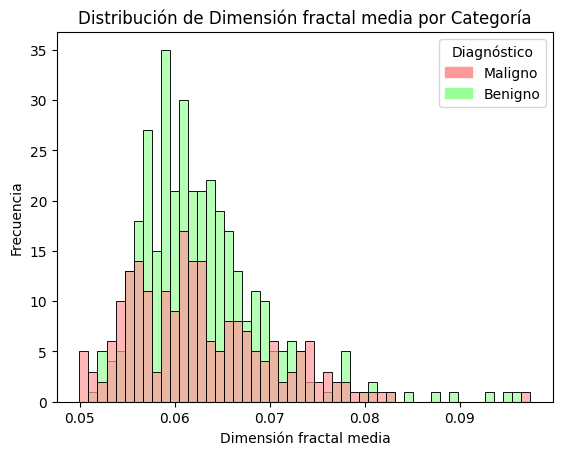

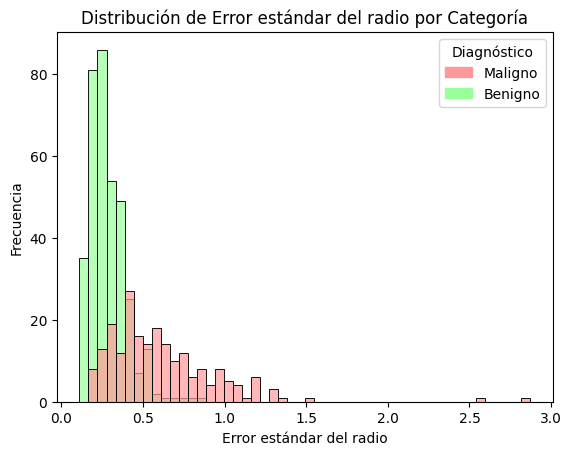

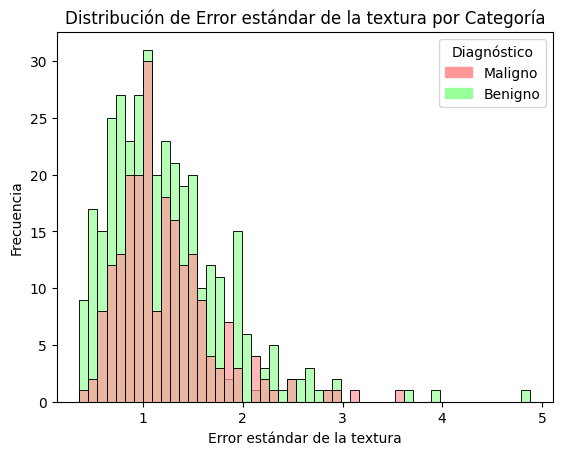

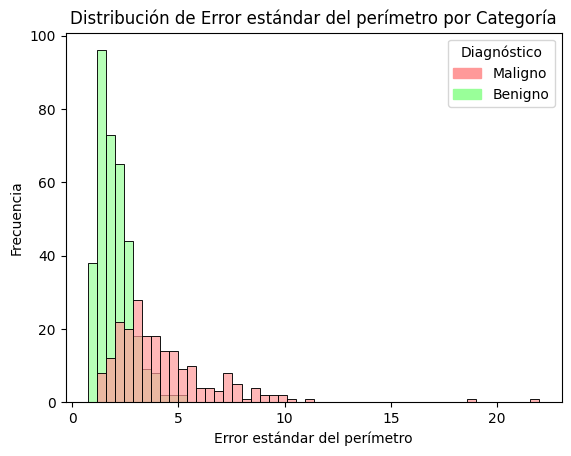

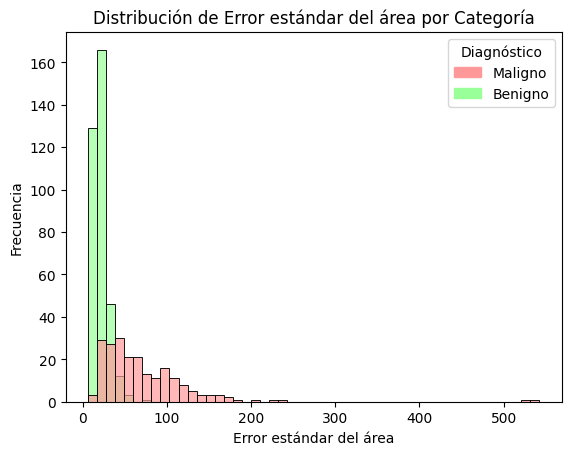

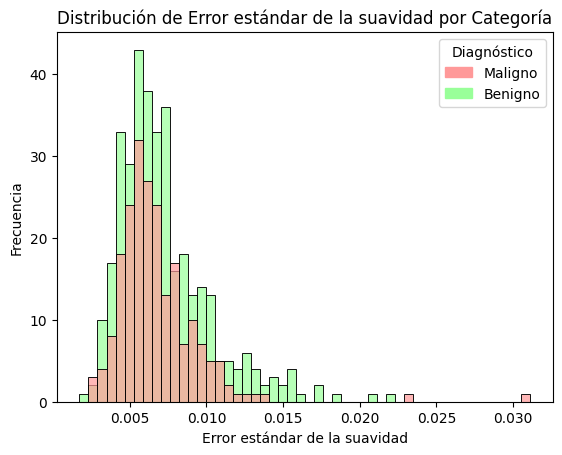

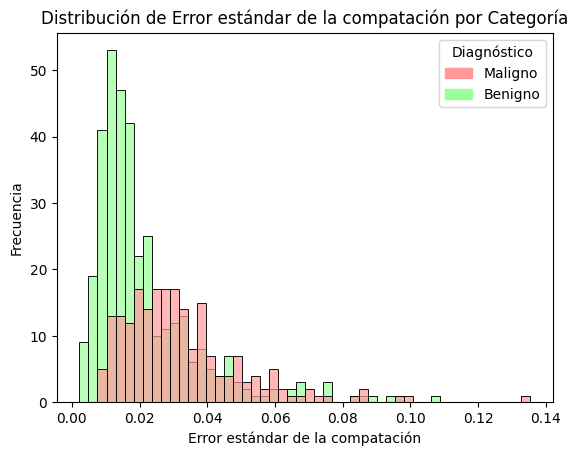

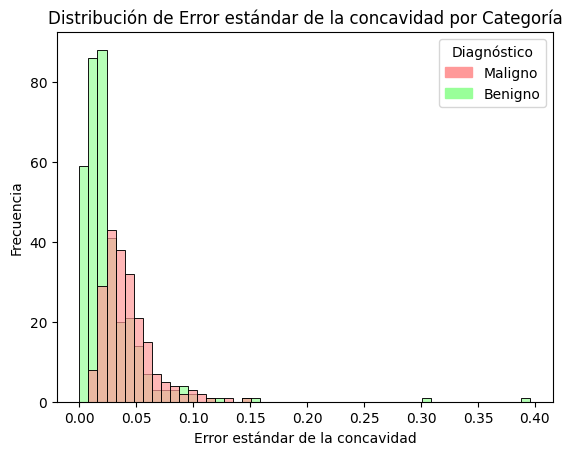

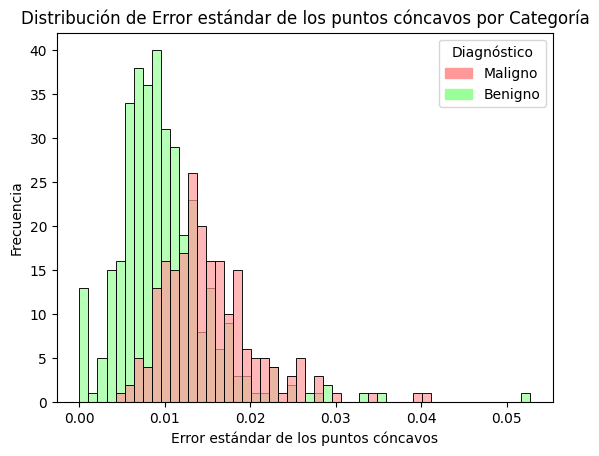

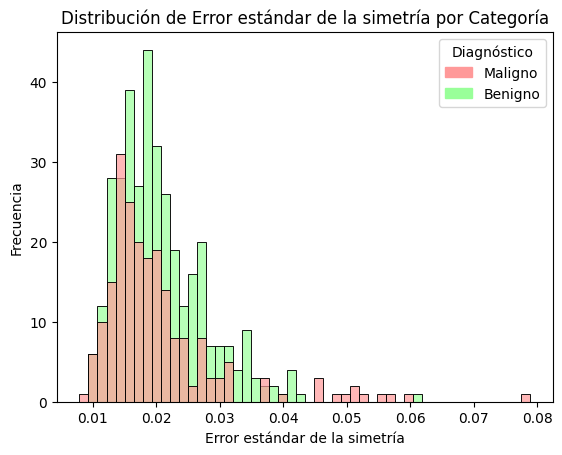

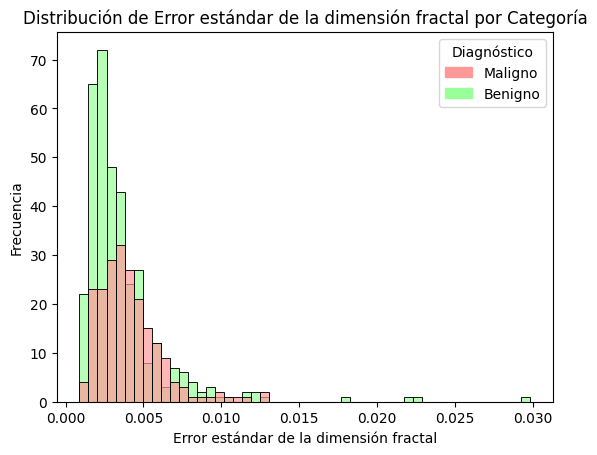

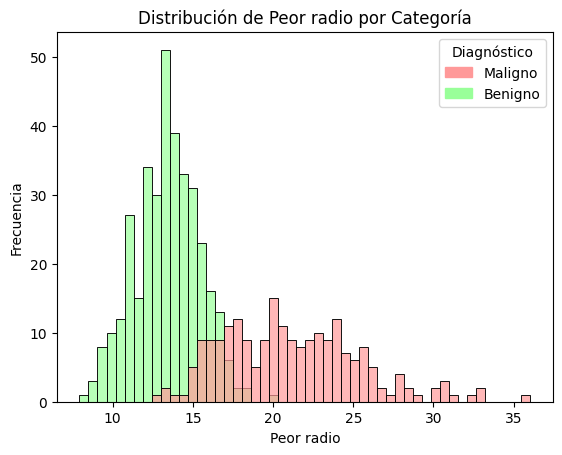

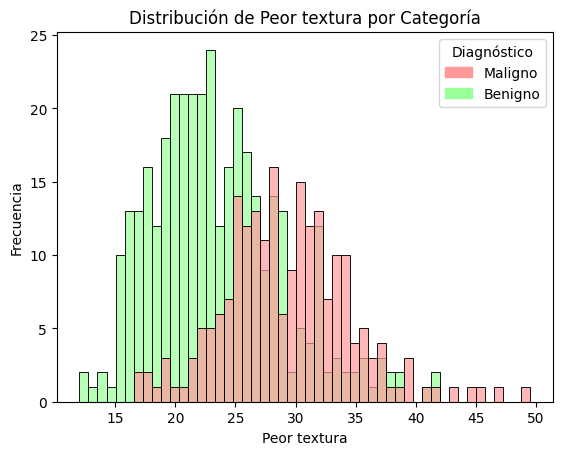

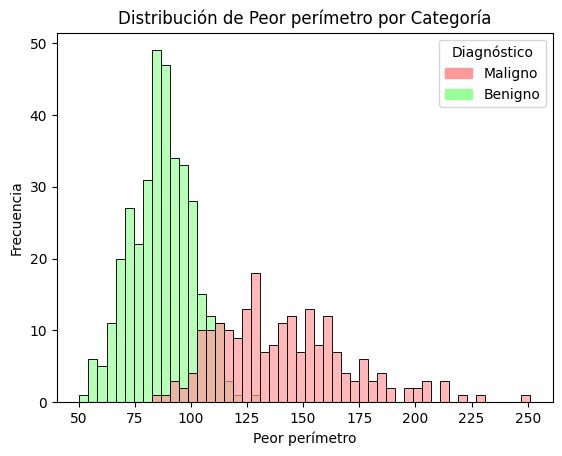

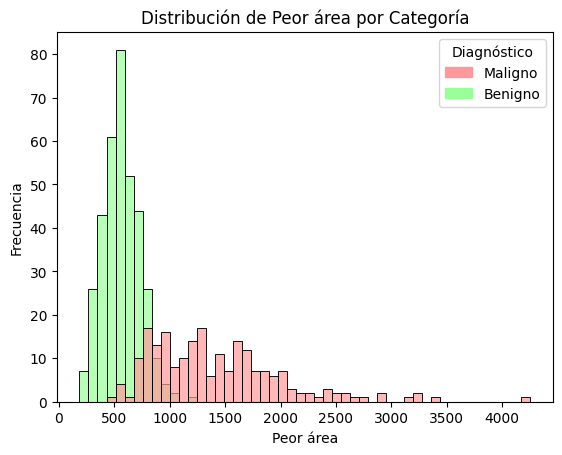

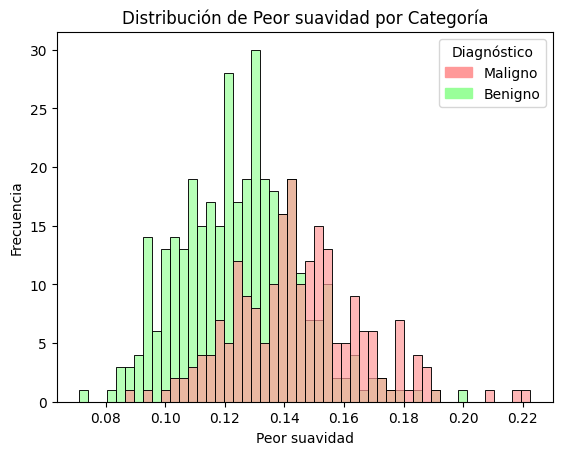

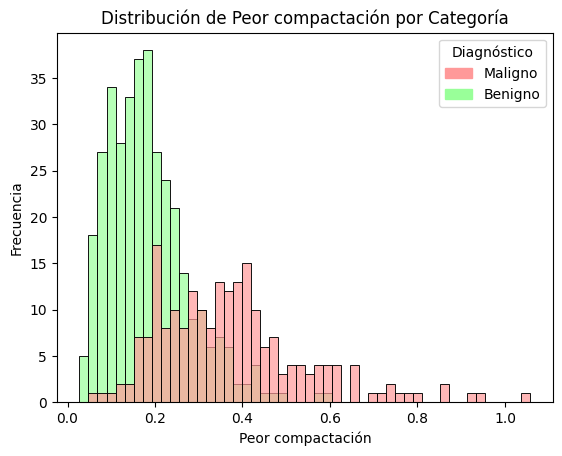

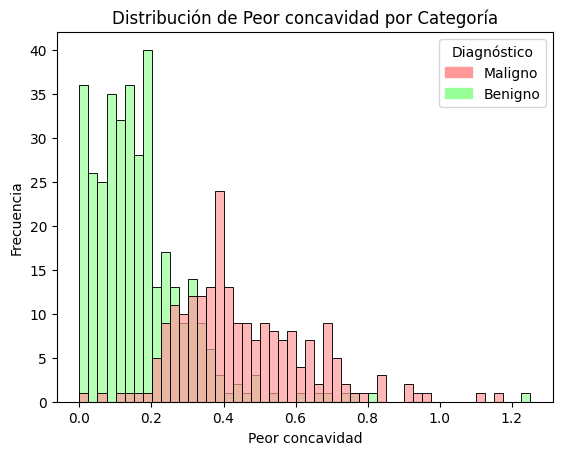

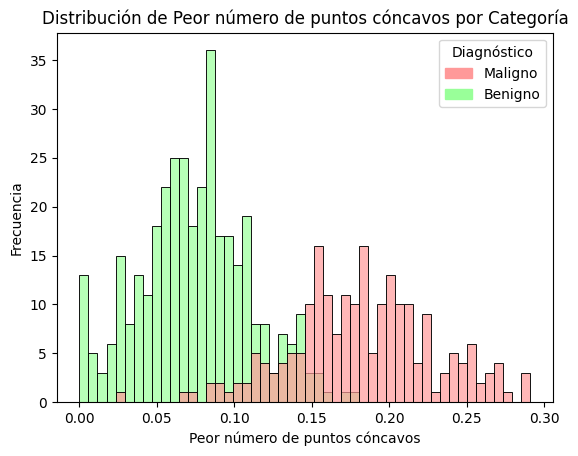

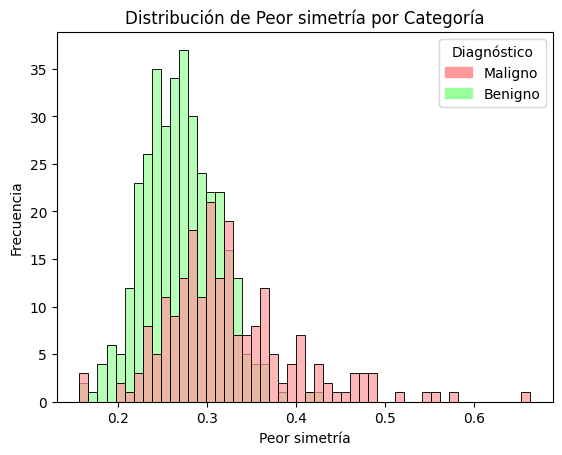

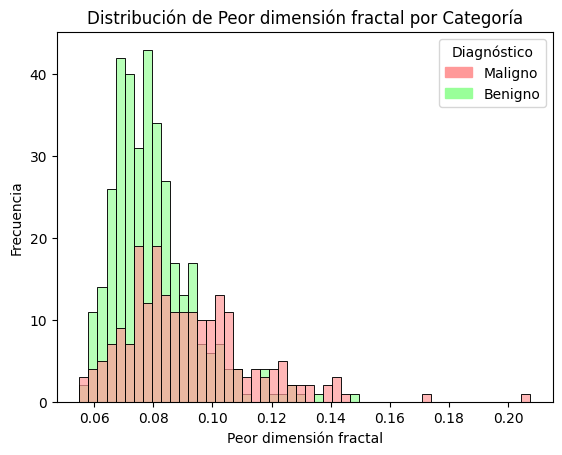

In [32]:
# Crea histogramas para cada variable segun target
for feature in num_columns:
    sns.histplot(data=df, x=feature, hue='target', bins=50, alpha=0.7, palette=palette)
    plt.xlabel(features_esn[feature])
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución de {features_esn[feature]} por Categoría')

    handles = [patches.Patch(color=palette[0], label='Maligno'), patches.Patch(color=palette[1], label='Benigno')]
    plt.legend(handles=handles, title='Diagnóstico')
    
    plt.show()


Observaciones: En el caso benigno la media y desvío estándar de las características son menores que en el caso maligno. En el caso de la media el resultado es esperable dado que tumores con valores medios de peor radio (o radio medio) o peores puntos concavos (entre otros) mayores tiende a ser un diagnóstico de tumor maligno. Además, en algunos casos como en 'peor número de puntos concavos' ambas distribuciones (maligno/beningo) se encuentran separadas (si bien existe zona de superposción) permitiendo definir rangos empíricos de diagnóstico. En otros casos ambas distribuciones se superponen, lo que dificulta definir umbral de separación de clases. También se observó que las frecuencias máximas en el caso maligno son menores que en el caso benigno.

### Distribución de categorías

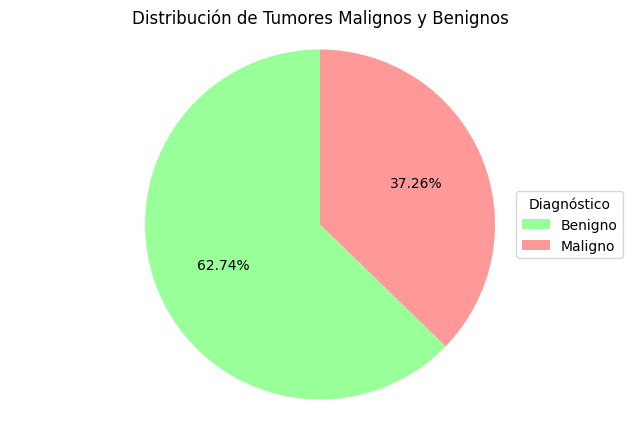

In [33]:
class_counts = df['target'].value_counts()

labels = ['Benigno', 'Maligno']

plt.figure(figsize=(8, 5))
plt.pie(class_counts, autopct='%1.2f%%', colors=['#99ff99', '#ff9999'], startangle=90)
plt.title('Distribución de Tumores Malignos y Benignos')
plt.axis('equal')  # Iguala el aspecto del gráfico para que sea un círculo

plt.legend(labels=labels, title='Diagnóstico', loc='right')

plt.show()

Observaciones: La cardinalidad de la variable categórica es baja, ya que presenta solo dos estados posibles: Maligno ó Benigno. Además, los casos malignos representan aproximadamente el 50% de los casos benignos, lo que puso en evidencia que las clases están desbalanceadas. Esto invita a realizar un escalado de las características. 

### Correlación entre atributos

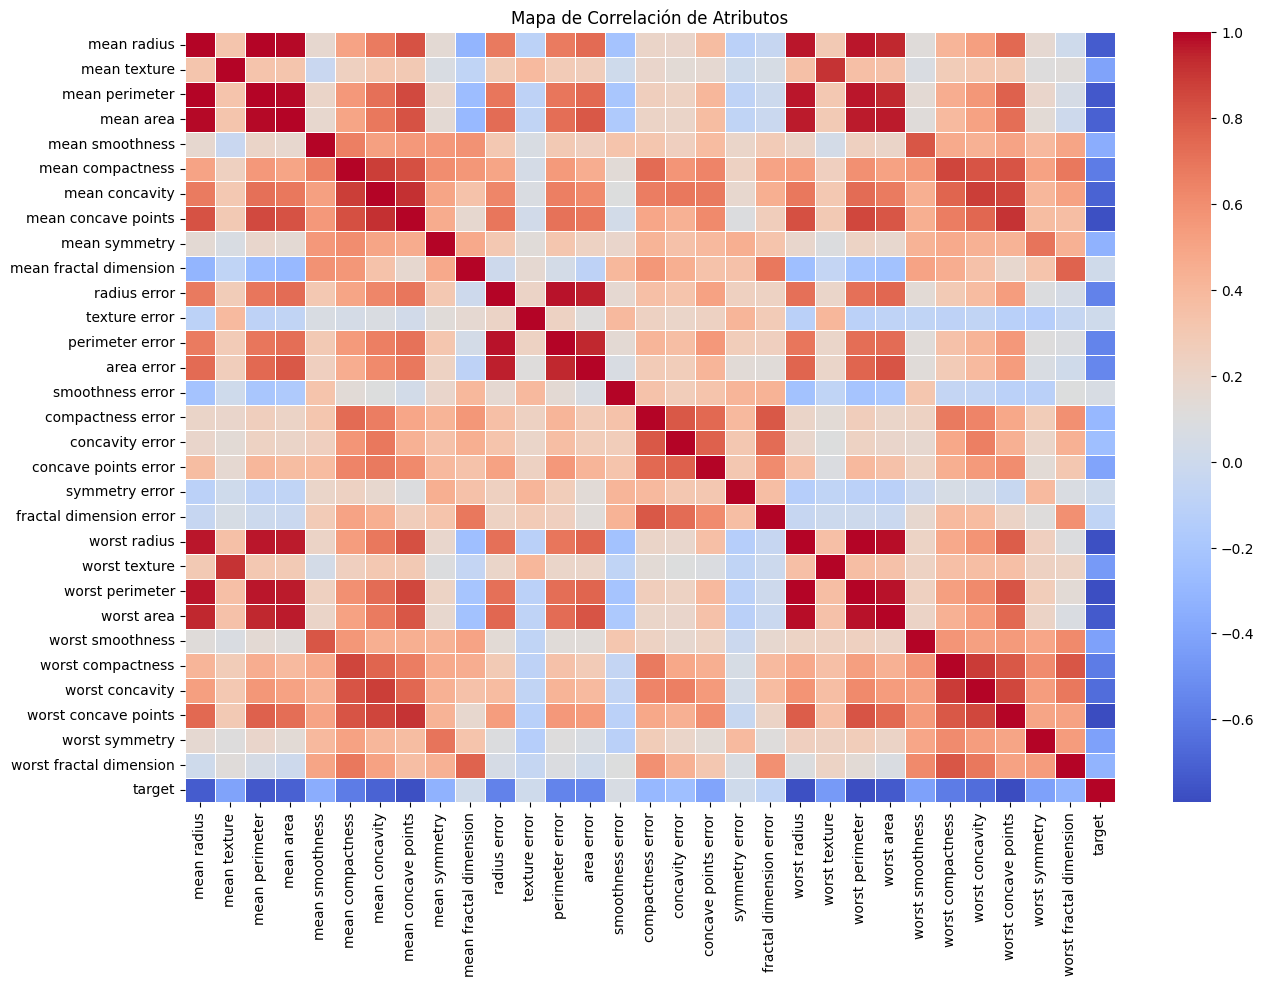

In [34]:
plt.figure(figsize=(15, 10))
correlation = df.corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Correlación de Atributos')
plt.show()

In [35]:
# Correlacion de cada atributo con el target
correlation_with_target = correlation['target'].sort_values(ascending=False)
print(correlation_with_target)


target                     1.000000
smoothness error           0.067016
mean fractal dimension     0.012838
texture error              0.008303
symmetry error             0.006522
fractal dimension error   -0.077972
concavity error           -0.253730
compactness error         -0.292999
worst fractal dimension   -0.323872
mean symmetry             -0.330499
mean smoothness           -0.358560
concave points error      -0.408042
mean texture              -0.415185
worst symmetry            -0.416294
worst smoothness          -0.421465
worst texture             -0.456903
area error                -0.548236
perimeter error           -0.556141
radius error              -0.567134
worst compactness         -0.590998
mean compactness          -0.596534
worst concavity           -0.659610
mean concavity            -0.696360
mean area                 -0.708984
mean radius               -0.730029
worst area                -0.733825
mean perimeter            -0.742636
worst radius              -0

In [36]:
# Umbral asumido => Maxima correlacion entre atributos
threshold = 0.7

# Pares de atributos con correlación alta (> 0.7 o < -0.7)
high_correlation_pairs = (correlation.abs() > 0.7) & (correlation != 1.0)
high_correlation_attrs = correlation[high_correlation_pairs]

pairs = set()
for i in high_correlation_attrs.index:
    for j in high_correlation_attrs.columns:
        if pd.notna(high_correlation_attrs.loc[i, j]):
            index = tuple(sorted([i, j]))
            pairs.add((*index, high_correlation_attrs.loc[i, j]))

for k in pairs:
    print(f"{k[0]} - {k[1]} : {k[2]}")

target - worst area : -0.7338250349210507
area error - perimeter error : 0.9376554069544157
mean area - worst area : 0.9592133256498998
perimeter error - radius error : 0.9727936770160764
mean smoothness - worst smoothness : 0.8053241954943627
worst area - worst concave points : 0.7474188023228167
mean compactness - worst concave points : 0.8155732235690644
mean area - worst concave points : 0.7220166262603579
mean texture - worst texture : 0.912044588840421
mean fractal dimension - worst fractal dimension : 0.7672967792384361
area error - worst perimeter : 0.7612126360687592
mean area - mean radius : 0.9873571700566127
area error - radius error : 0.951830112110991
area error - mean radius : 0.7358636632128178
mean perimeter - mean radius : 0.9978552814938109
mean compactness - mean concave points : 0.831135043133698
mean concavity - worst concave points : 0.861323033637951
perimeter error - worst perimeter : 0.7210313099890175
mean area - mean perimeter : 0.9865068039913907
concavity 

Observaciones: En el mapa de índices de correlación, se detectan dos diagonales, abajo a la izquierda y arriba a la derecha del mapa. Esto está asociado la elevada correlación que hay entre el valor medio de una característica y el peor valor de la misma. Con esto se pone en evidencia la existencia de dependencia (lineal) entre estas características.

Para trabajar con un conjunto de características independientes, parecería conveniente eliminar los datos relacionados con los peores valores de los atributos  y quedarse con los valores medios. Para esto se puede usar un umbral de correlación de 0,7 (Guyon y Elisseeff, 2003).

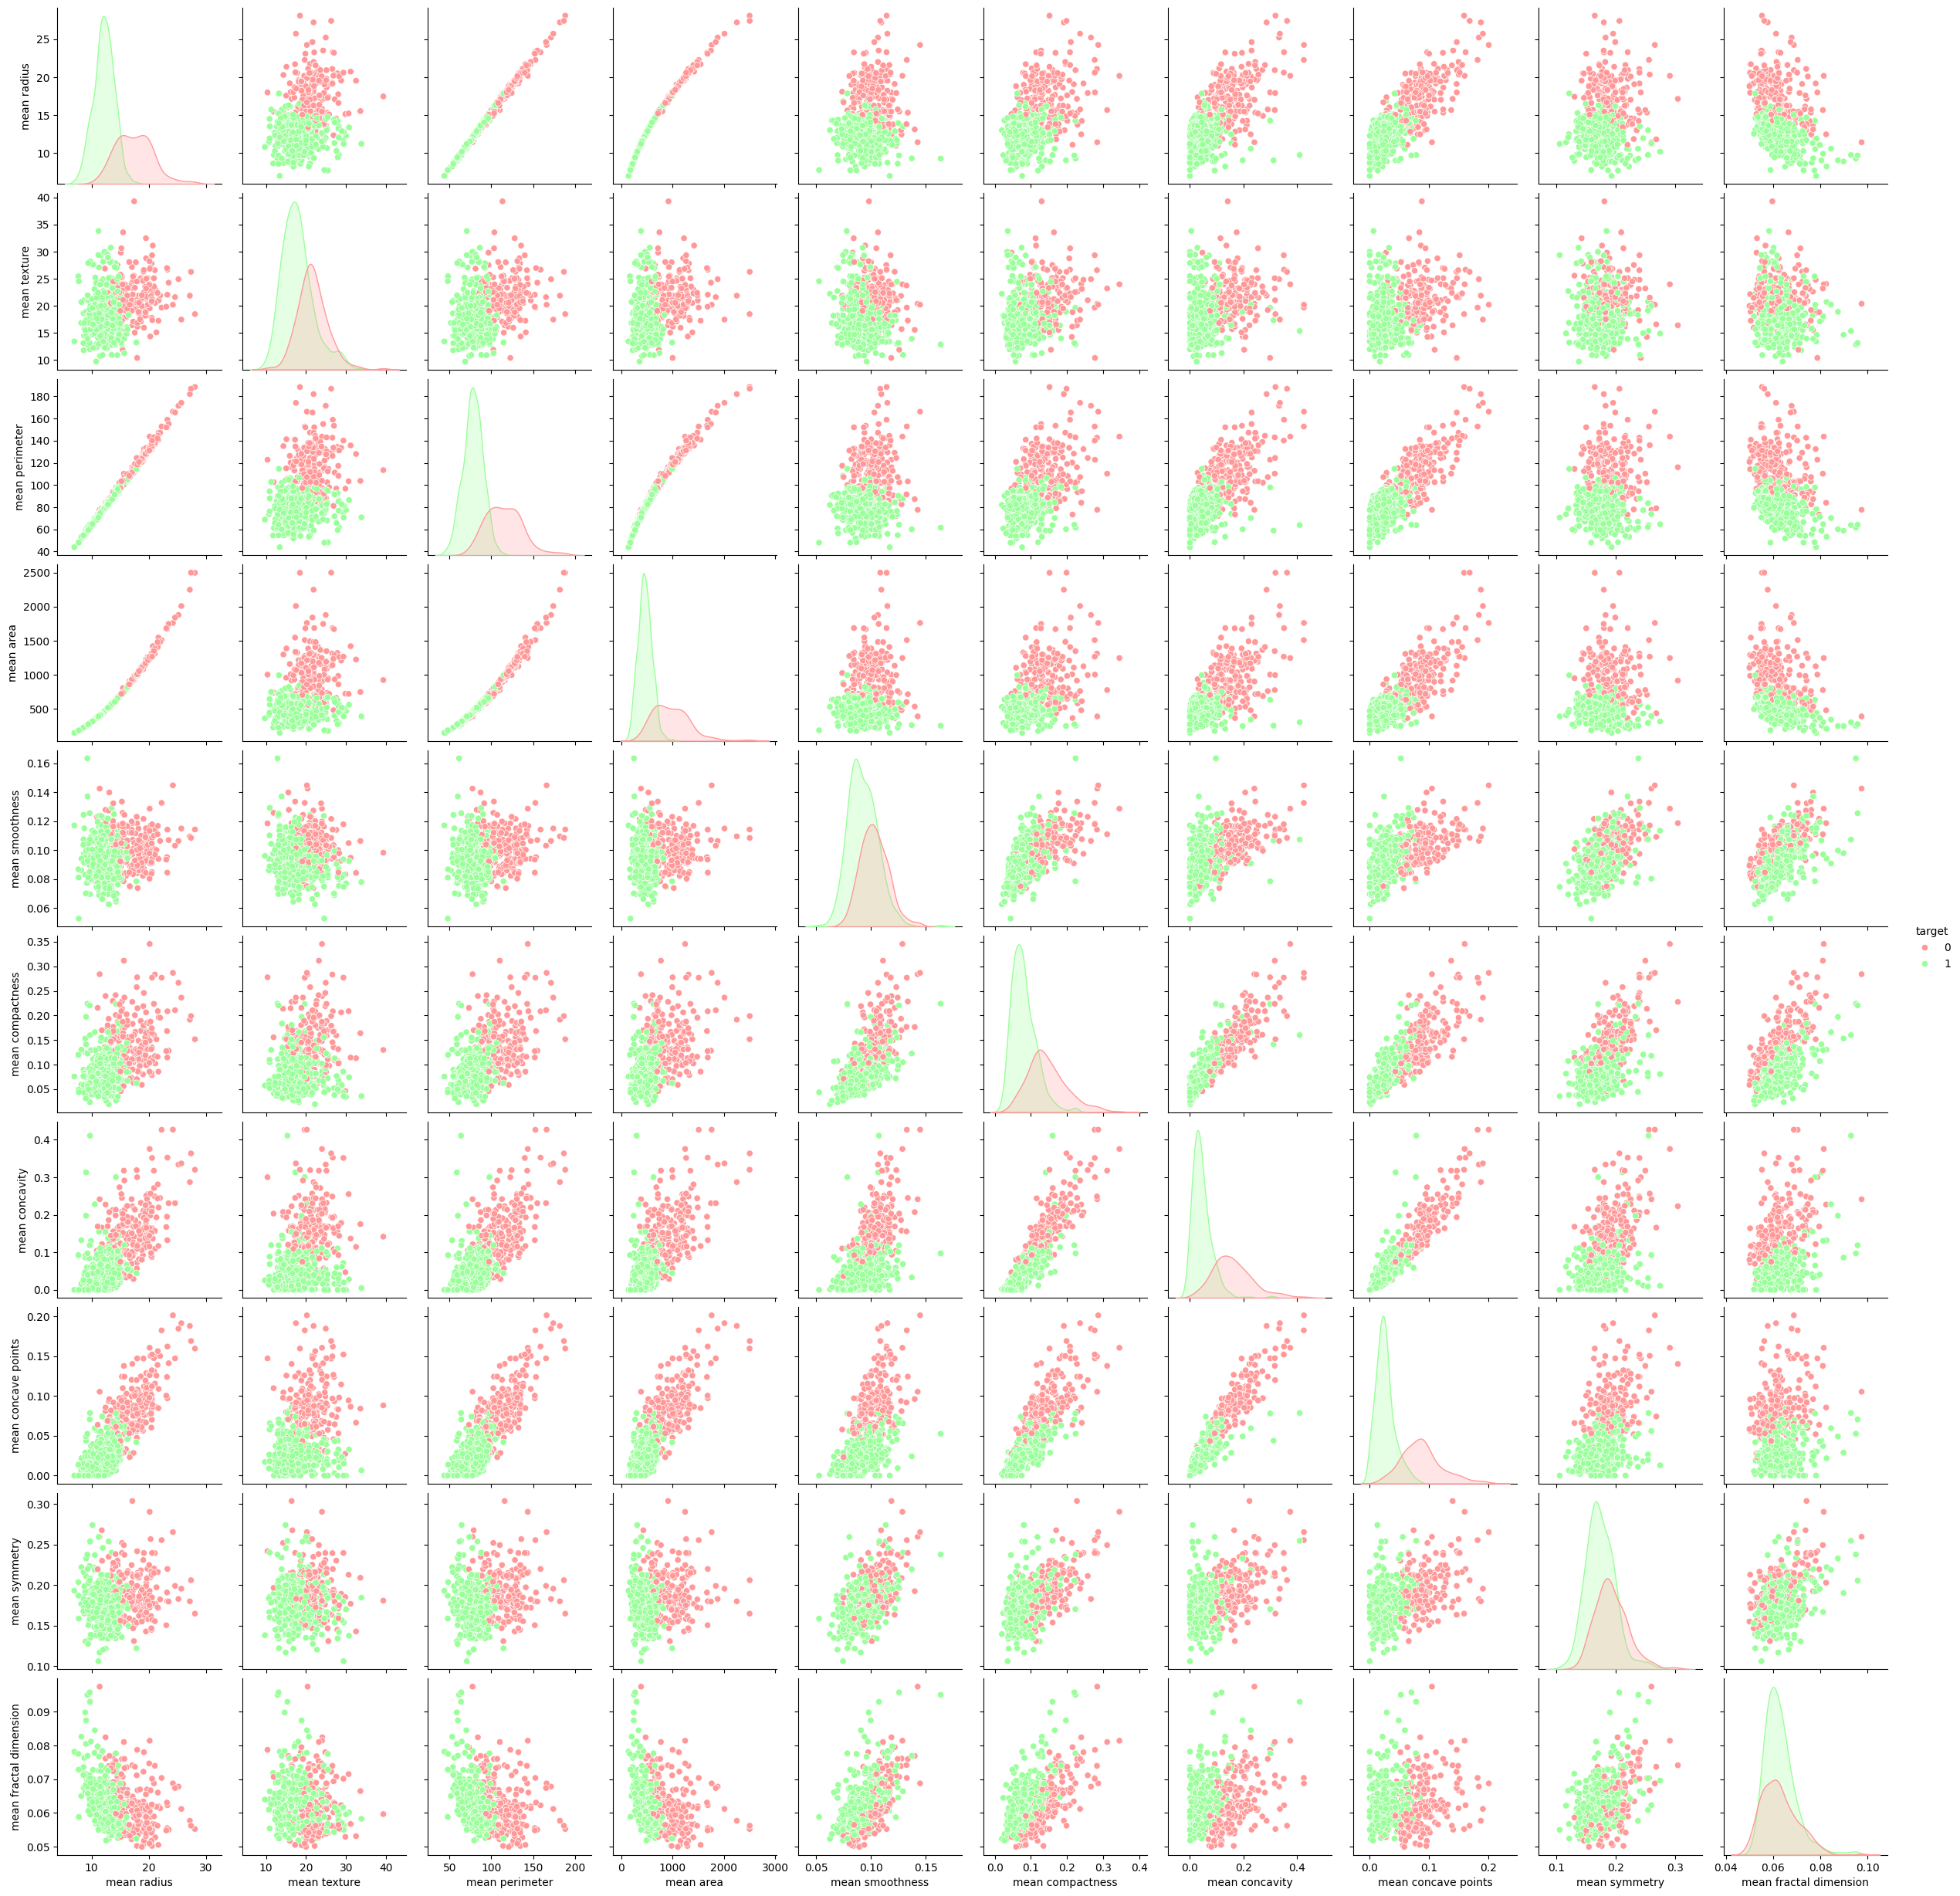

In [37]:
df_mean = df.filter(regex='mean|target')
sns.pairplot(data=df_mean, diag_kind="kde", hue='target', palette=palette);

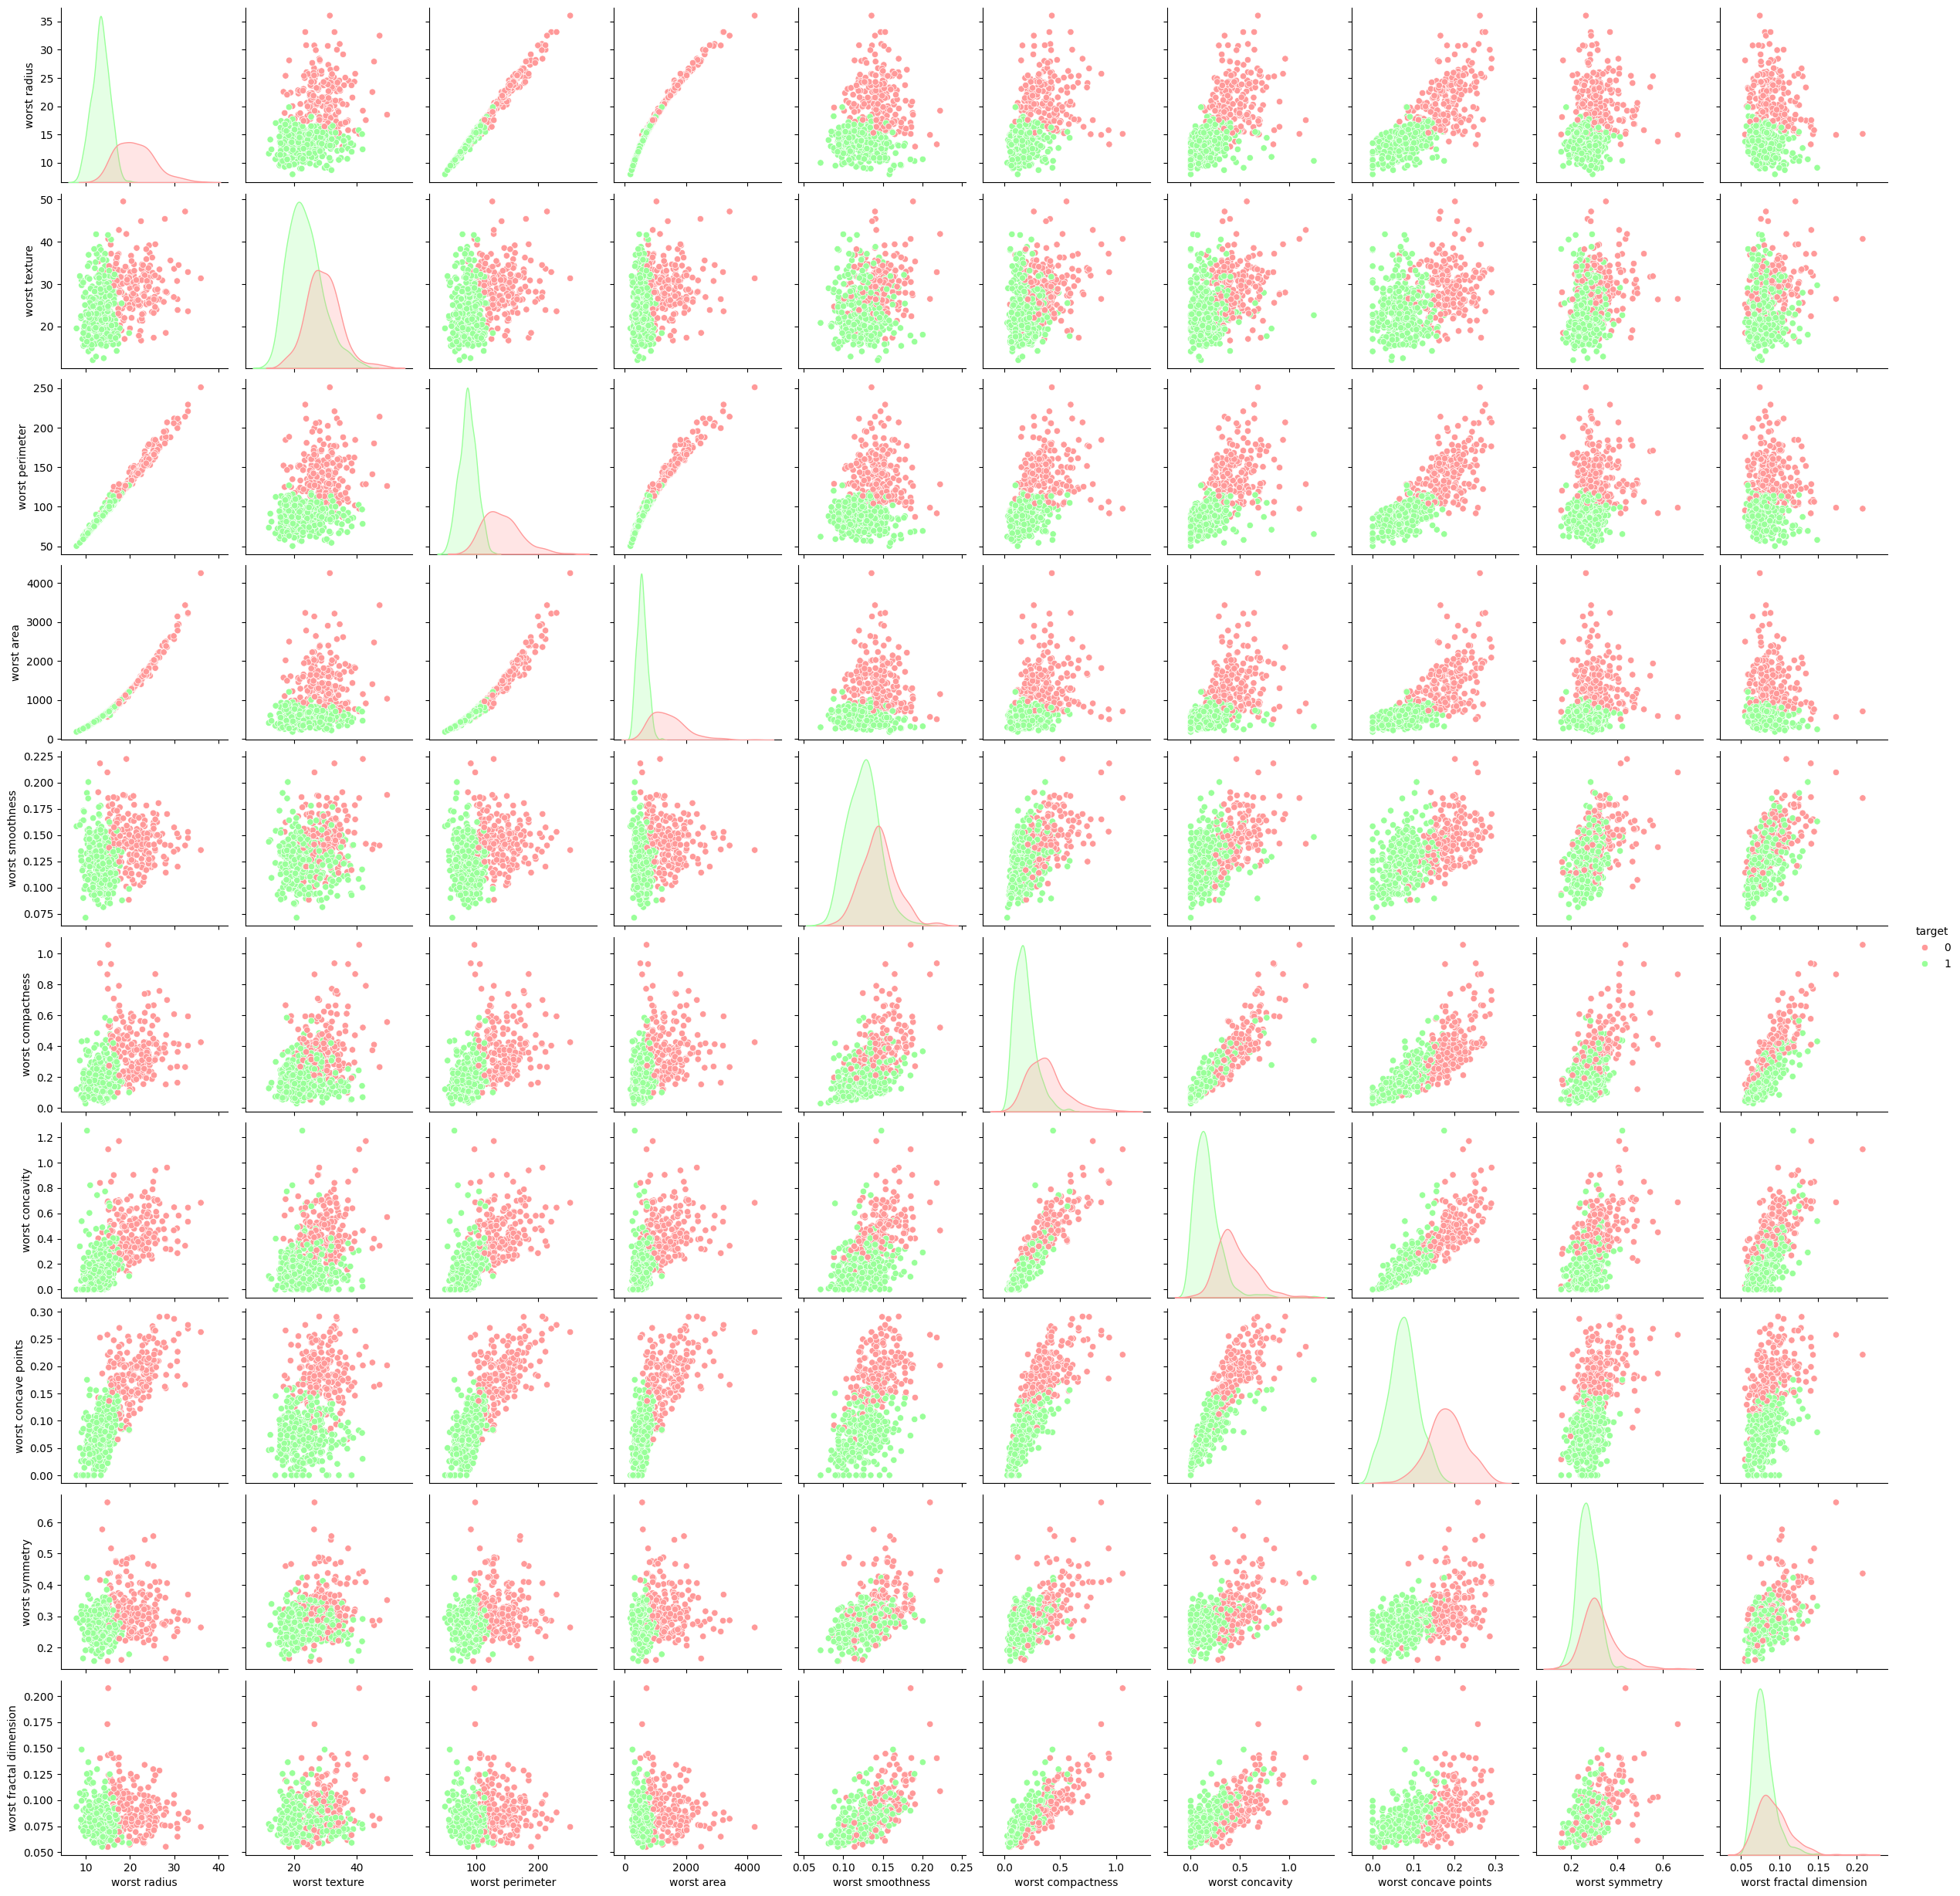

In [38]:
df_worst = df.filter(regex='worst|target')
sns.pairplot(data=df_worst, diag_kind="kde", hue='target', palette=palette);

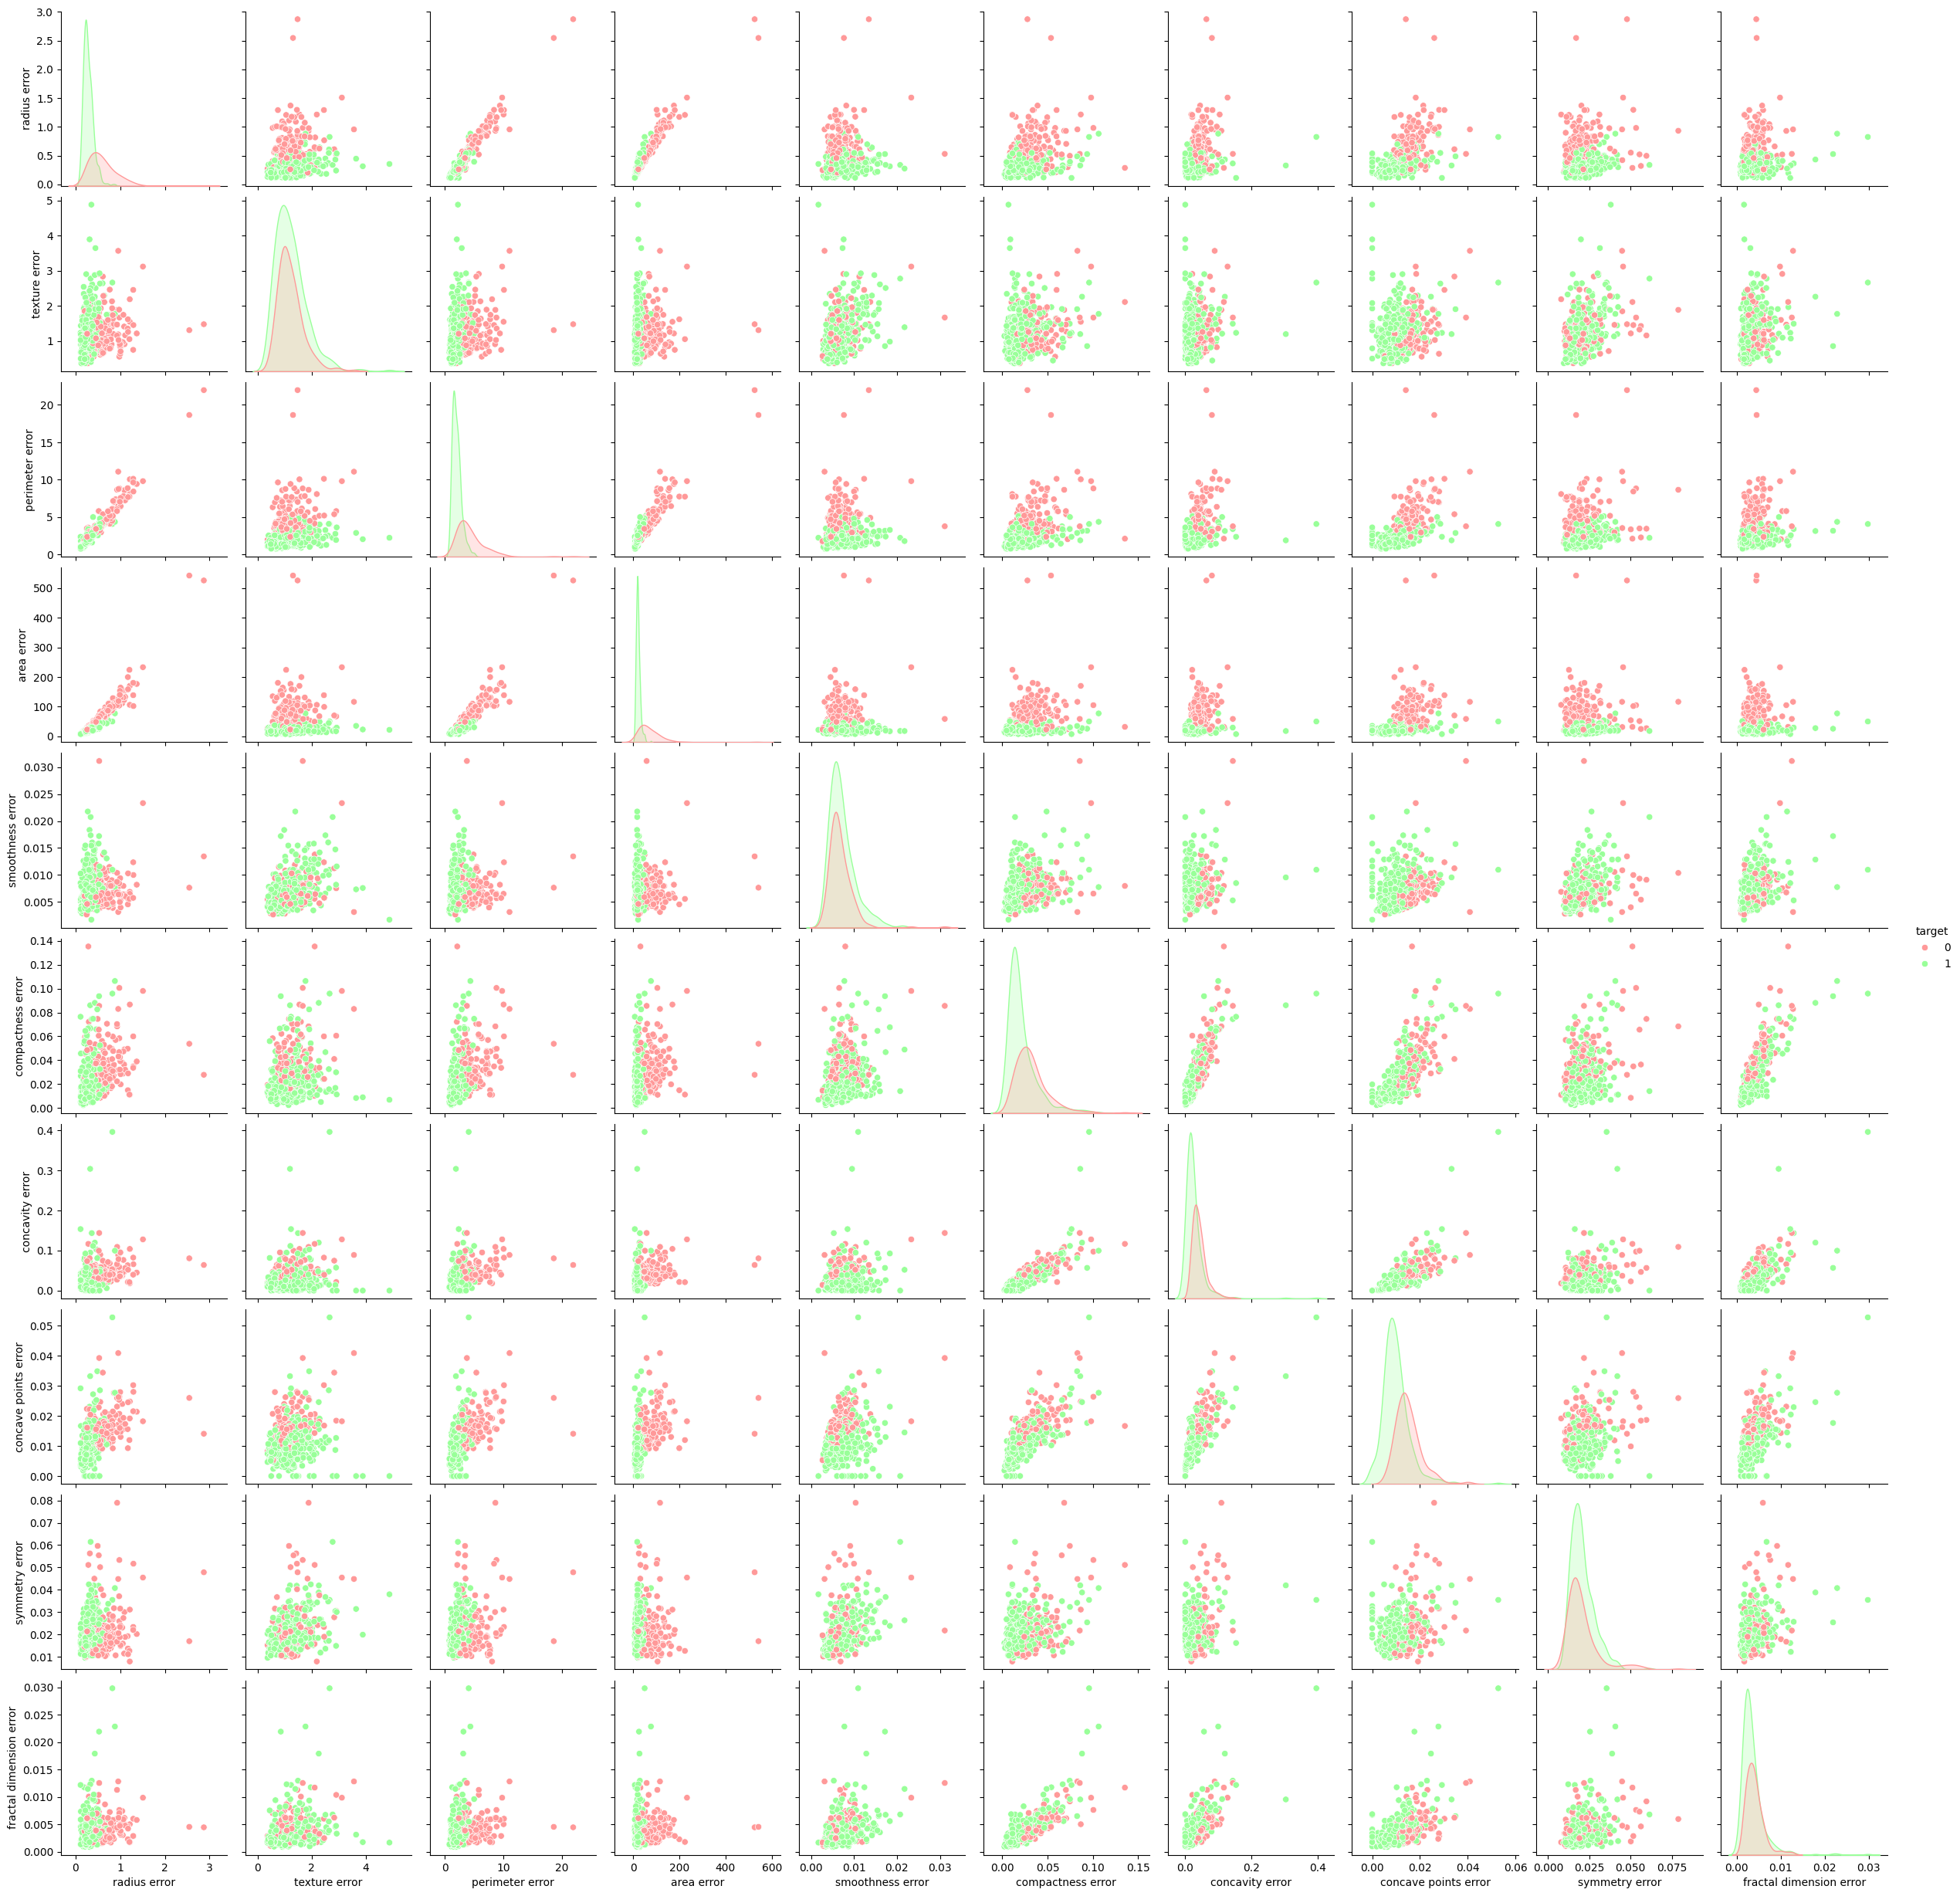

In [39]:
df_error = df.filter(regex='error|target')
sns.pairplot(data=df_error, diag_kind="kde", hue='target', palette=palette);

Observaciones: Es interesante resaltar la marcada dependencia lineal que existe entre el radio y el perímetro y la dependencia cuadrática entre estos y el área. Esto tiene sentido si consideramos a los tumores con una forma aproximadamente circular.

### Box plots

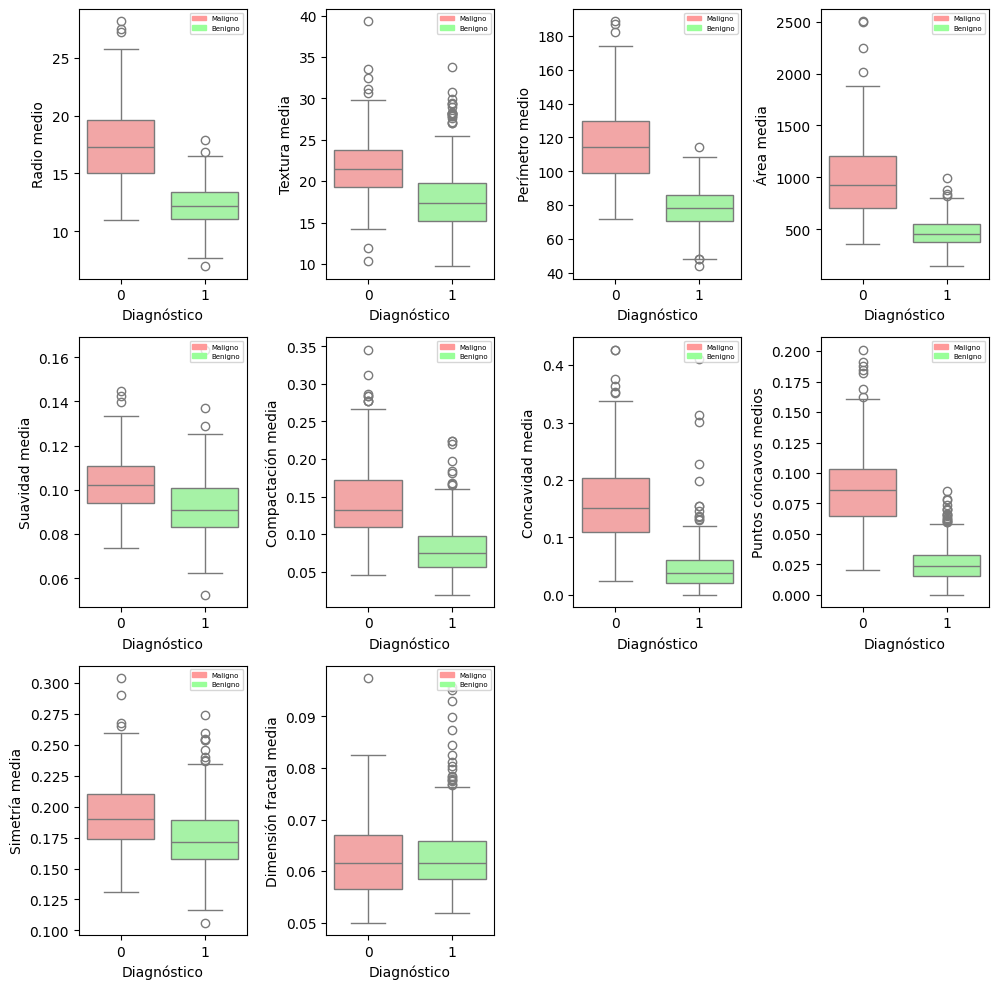

In [40]:
plt.figure(figsize=(10, 10))

for i, feature in enumerate(df_mean.drop(columns='target')):
    plt.subplot(10 // 4 + 1, 4, i + 1)  
    sns.boxplot(data=df, x='target', y=feature, palette=palette, hue='target')
    plt.xlabel('Diagnóstico')
    plt.ylabel(features_esn[feature])
    handles = [patches.Patch(color=palette[0], label='Maligno'), patches.Patch(color=palette[1], label='Benigno')]
    plt.legend(handles=handles, fontsize='5', loc='upper right')

plt.tight_layout()
plt.show()


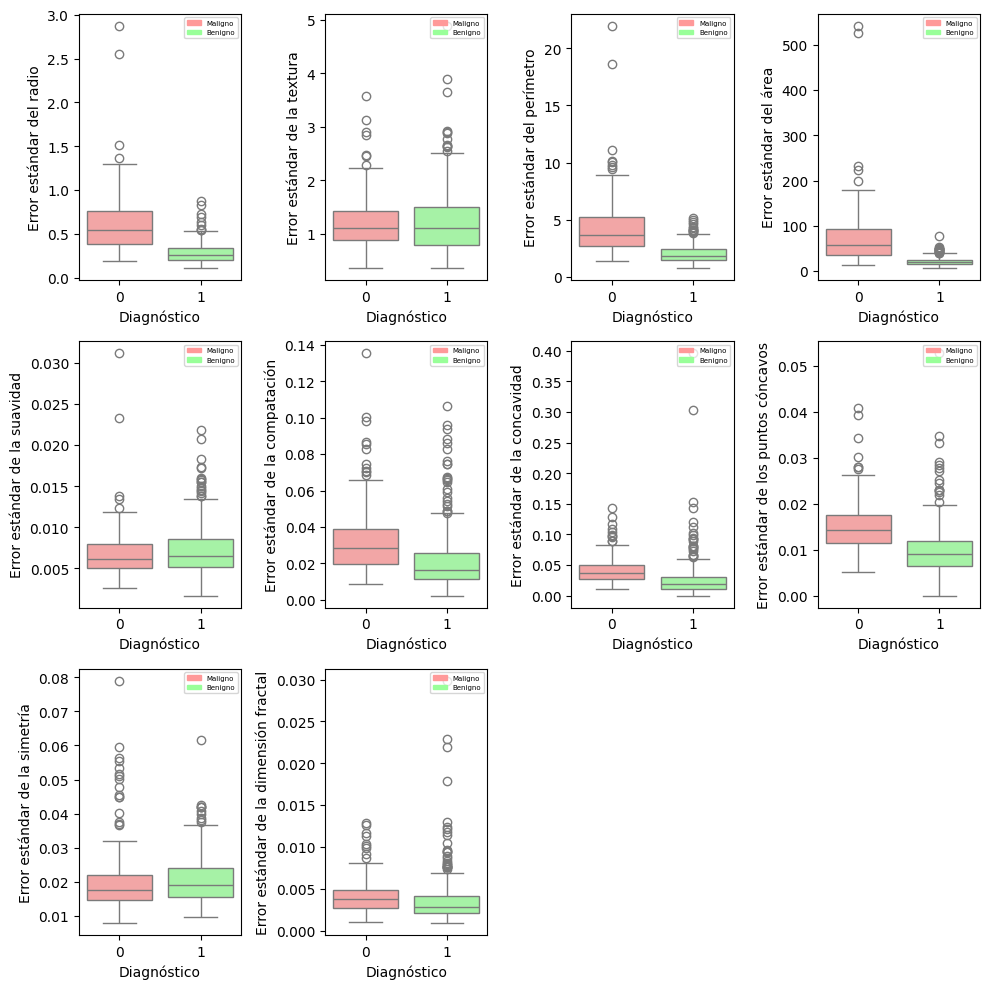

In [41]:
plt.figure(figsize=(10, 10))

for i, feature in enumerate(df_error.drop(columns='target')):
    plt.subplot(10 // 4 + 1, 4, i + 1)  
    sns.boxplot(data=df, x='target', y=feature, palette=palette, hue='target')
    plt.xlabel('Diagnóstico')
    plt.ylabel(features_esn[feature])
    handles = [patches.Patch(color=palette[0], label='Maligno'), patches.Patch(color=palette[1], label='Benigno')]
    plt.legend(handles=handles, fontsize='5', loc='upper right')

plt.tight_layout()
plt.show()

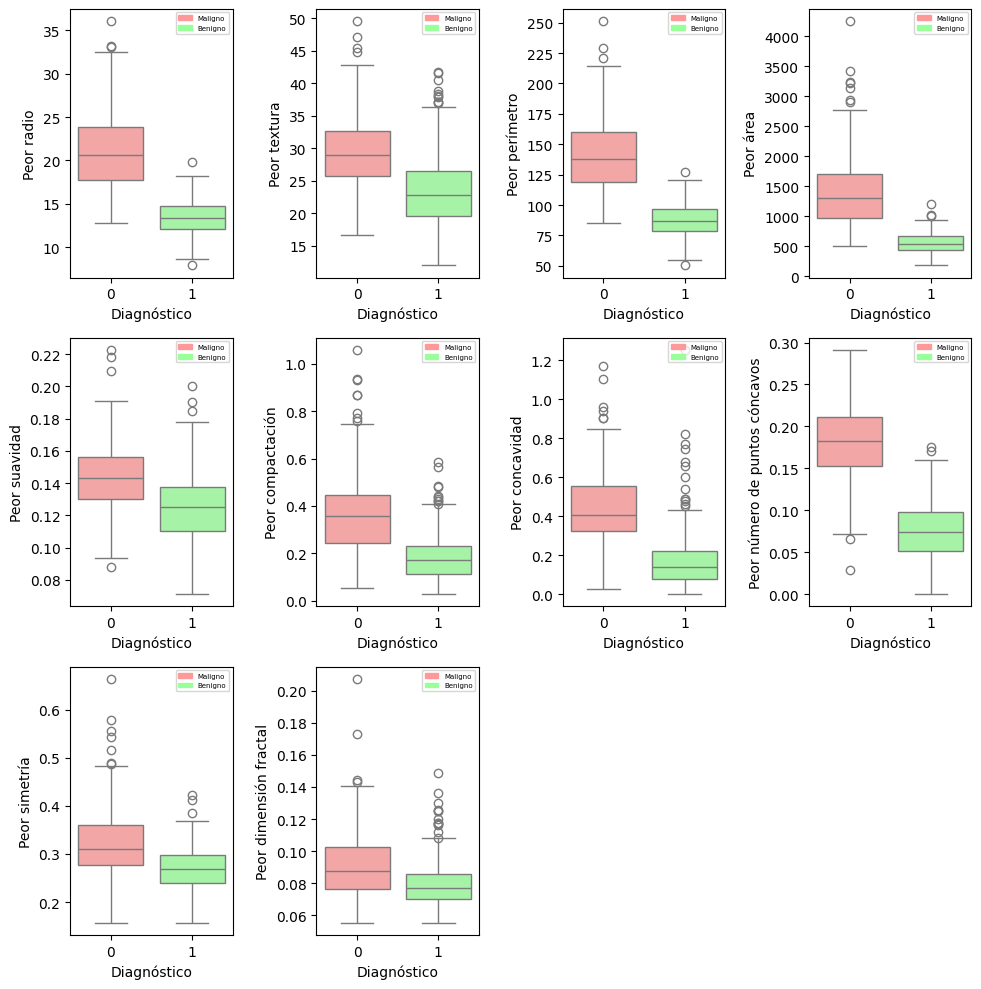

In [42]:
plt.figure(figsize=(10, 10))

for i, feature in enumerate(df_worst.drop(columns='target')):
    plt.subplot(10 // 4 + 1, 4, i + 1)  
    sns.boxplot(data=df, x='target', y=feature, palette=palette, hue='target')
    plt.xlabel('Diagnóstico')
    plt.ylabel(features_esn[feature])
    handles = [patches.Patch(color=palette[0], label='Maligno'), patches.Patch(color=palette[1], label='Benigno')]
    plt.legend(handles=handles, fontsize='5', loc='upper right')

plt.tight_layout()
plt.show()

Observaciones: En este punto podría aplicarse una técnica para los *outliers* identificados como poda por ejemplo, pero como se verá más adelante el conjunto de observaciones original ya presenta los mejores resultados de performance de modelos de aprendizaje supervisado. Por este motivo se decidió no manipularlos.

### Selección de características

In [43]:
# Entrena el modelo Decision Tree
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [44]:
# Predice y evalua el modelo con todas las caracteristicas
y_pred_all_features = model.predict(X_test)
accuracy_all_features = accuracy_score(y_test, y_pred_all_features)
print(f'Precisión con todas las características: {accuracy_all_features:.2f}')

Precisión con todas las características: 0.94


In [45]:
# Obtiene la importancia de las caracteristicas
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns, 
    'Importance': importances}).sort_values(by='Importance', ascending=False)

# Muestra la importancia de las caracteristicas
print("Importancia de las características:")
print(feature_importance_df)


Importancia de las características:
                    Feature  Importance
7       mean concave points    0.705839
21            worst texture    0.114062
20             worst radius    0.070187
23               worst area    0.036653
1              mean texture    0.022885
17     concave points error    0.017164
13               area error    0.013563
24         worst smoothness    0.010492
16          concavity error    0.007152
14         smoothness error    0.002004
19  fractal dimension error    0.000000
0               mean radius    0.000000
18           symmetry error    0.000000
25        worst compactness    0.000000
26          worst concavity    0.000000
27     worst concave points    0.000000
28           worst symmetry    0.000000
22          worst perimeter    0.000000
15        compactness error    0.000000
12          perimeter error    0.000000
11            texture error    0.000000
10             radius error    0.000000
9    mean fractal dimension    0.000000
8   

In [46]:
# Selecciona las caracteristicas mas importantes
selector = SelectFromModel(model, prefit=True, threshold=0.01)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Muestra las caracteristicas seleccionadas
selected_features = X.columns[selector.get_support()]
print("Características seleccionadas:")
print(selected_features)

Características seleccionadas:
Index(['mean texture', 'mean concave points', 'area error',
       'concave points error', 'worst radius', 'worst texture', 'worst area',
       'worst smoothness'],
      dtype='object')


c:\Users\SHIFTA-0164\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\SHIFTA-0164\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [47]:
# Entrena el modelo Decision Tree con las caracteristicas seleccionadas
model_selected = DecisionTreeClassifier(random_state=42)
model_selected.fit(X_train_selected, y_train)

# Predice y evaluar el modelo con las caracteristicas seleccionadas
y_pred_selected_features = model_selected.predict(X_test_selected)
accuracy_selected_features = accuracy_score(y_test, y_pred_selected_features)
print(f'Precisión con las características seleccionadas: {accuracy_selected_features:.2f}')

Precisión con las características seleccionadas: 0.95


In [48]:
print("Características seleccionadas:\n")
for item in selected_features:
    print(features_esn[item])

Características seleccionadas:

Textura media
Puntos cóncavos medios
Error estándar del área
Error estándar de los puntos cóncavos
Peor radio
Peor textura
Peor área
Peor suavidad


A continuación se muestran los resultados de estos experimentos de evaluación con el conjunto de prueba:

|Modelo                |Características|Método de selección   |Método de escalado|Precisión|
|----------------------|---------------|----------------------|------------------|---------|
|Árbol de clasificación|Todas          |Sin selección         |Sin escalado      |  0,94   |
|Árbol de clasificación|    8          |Árbol de clasificación|Sin escalado      |	0,95   |

Observaciones: Poco impacto en la precisión del modelo al aplicar este método de selección.


## 4. Desarrollo de modelos

Regresión Logística

In [49]:
def LogRegression (X_tr, y_tr, X_ts, y_ts):
    lregression = LogisticRegression(random_state = 42, class_weight="balanced")
    lregression.fit(X_tr, y_tr)

    y_pred_lr = lregression.predict(X_ts)

    ## Matriz de confusión
    cm_lr = confusion_matrix(y_ts, y_pred_lr)
    
    g_cm_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=lregression.classes_)
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]})
    
    ax0.axvline(x=0.5, color='gray', linestyle='--')
    ax0.axhline(y=0.5, color='gray', linestyle='--')
    ax0.text(0.25, 0.75, 'VERDADEROS\nNEGATIVOS', fontsize=12, ha='center', va='center')
    ax0.text(0.75, 0.75, 'FALSOS\nPOSITIVOS', fontsize=12, ha='center', va='center')
    ax0.text(0.25, 0.25, 'FALSOS\nNEGATIVOS', fontsize=12, ha='center', va='center')
    ax0.text(0.75, 0.25, 'VERDADEROS\nPOSITIVOS', fontsize=12, ha='center', va='center')
    ax0.set_xlim(0, 1)
    ax0.set_ylim(0, 1)
    ax0.axis('off')
    
    g_cm_lr.plot(ax=ax1, cmap='Greens')
    ax1.set_title("REGRESIÓN LOGÍSTICA")
    ax1.set_xlabel('Predicción') 
    ax1.set_ylabel('Valor verdadero') 
    
    plt.tight_layout()
    plt.show()

    metrics_data = [
    [f"{round(accuracy_score(y_ts, y_pred_lr)*100, 2)}%"],
    [round(precision_score(y_ts, y_pred_lr, zero_division=0), 4)],    
    [round(recall_score(y_ts, y_pred_lr, zero_division=0), 4)]
    ]
    
    metrics = pd.DataFrame(metrics_data, 
                           columns=['REGRESION LOGISTICA'], 
                           index=['Accuracy', 'Precision', 'Recall'])
    
    display(metrics)

    y_probs_lr = lregression.predict_proba(X_ts)[:, -1]

    fp_lr, p_lr, thresholds_lr = roc_curve(y_ts, y_probs_lr)
    
    plt.figure(figsize=(5, 5))
    plt.plot(fp_lr, p_lr, color='green', label="Regresión Logística")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.title('Curva ROC')
    plt.legend()
    plt.grid(True)
    plt.show()

    auc_lr = auc(fp_lr, p_lr)
    print(f"AUC Regresión Logística = {auc_lr}")
    # El área bajo la curva de ser cercana a 1

Dataset con datos sin escalar:


c:\Users\SHIFTA-0164\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


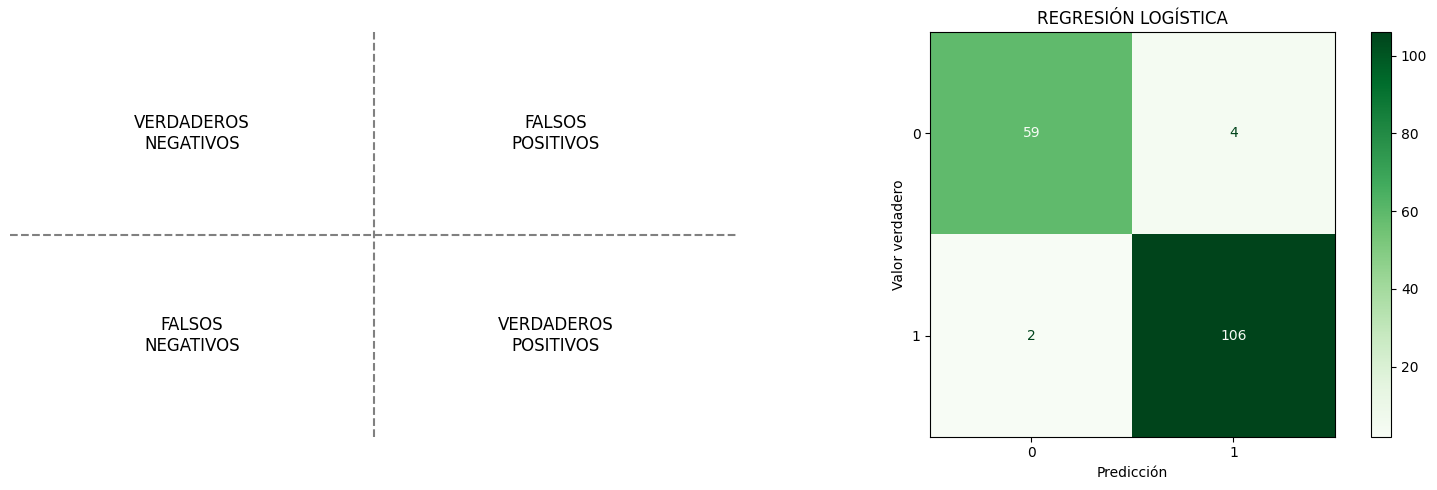

REGRESION LOGISTICA
Accuracy               96.49%
Precision              0.9636
Recall                 0.9815

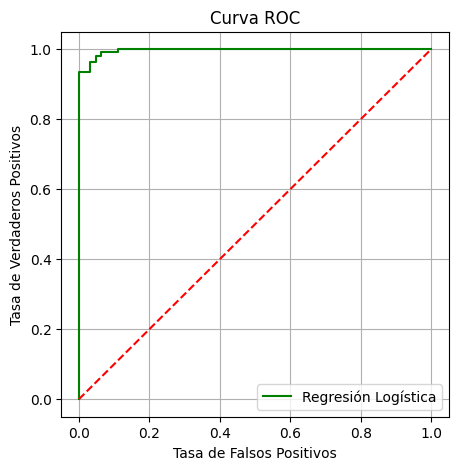

AUC Regresión Logística = 0.9966196355085244


In [50]:
print ("Dataset con datos sin escalar:")
LogRegression (X_train, y_train, X_test, y_test)

De manera similar al experimento con árboles de clasificación, se resume el desempeño con regresión logística:

|Modelo             |Características|Método de selección|Método de escalado|Precisión|Recall| AUC |
|-------------------|---------------|-------------------|------------------|---------|------|-----|
|Regresión Logística|Todas          |Sin selección      |Sin escalado      |   0,96  | 0,98 |1,00 |

Observaciones: Modificando el modelo se volvió a obtener muy buen desempeó usando el conjunto de prueba.


Se repite lo anterior pero sin selección de características probando diferentes escalados.


Datos escalados con StandardScaler


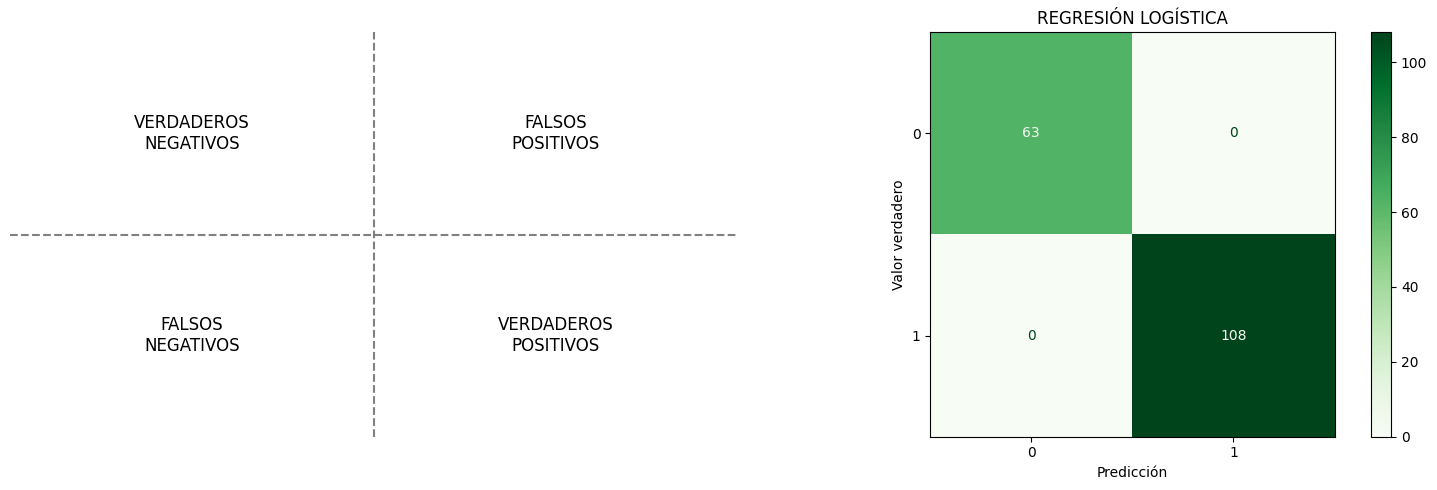

REGRESION LOGISTICA
Accuracy               100.0%
Precision                 1.0
Recall                    1.0

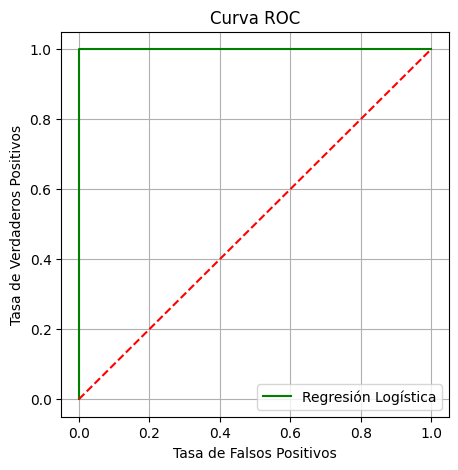

AUC Regresión Logística = 1.0

Datos escalados con MinMaxScaler


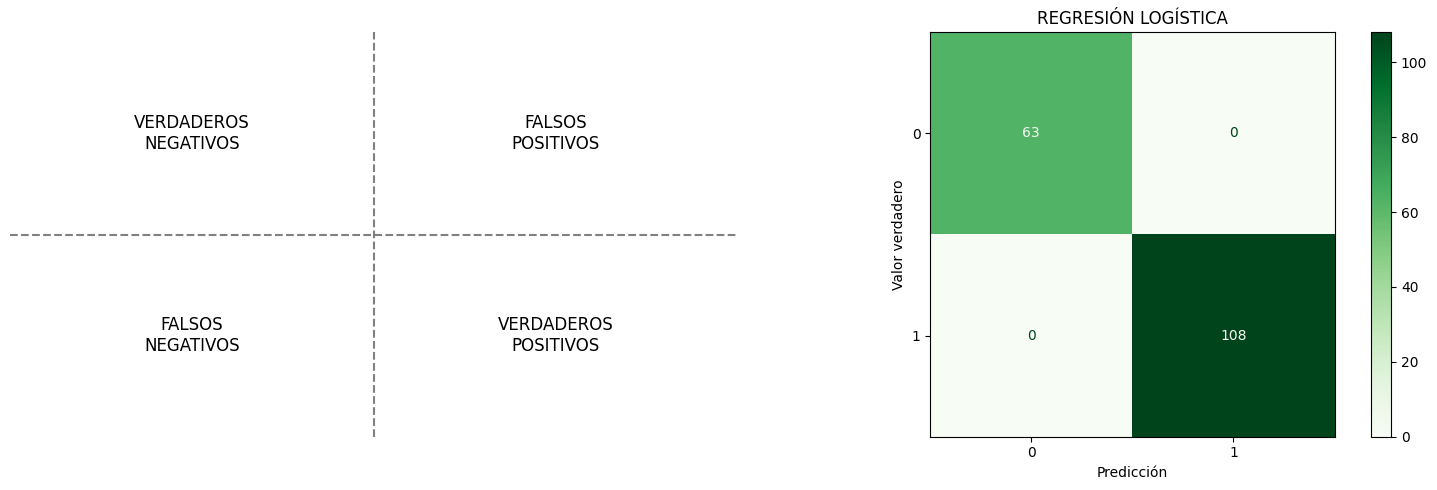

REGRESION LOGISTICA
Accuracy               100.0%
Precision                 1.0
Recall                    1.0

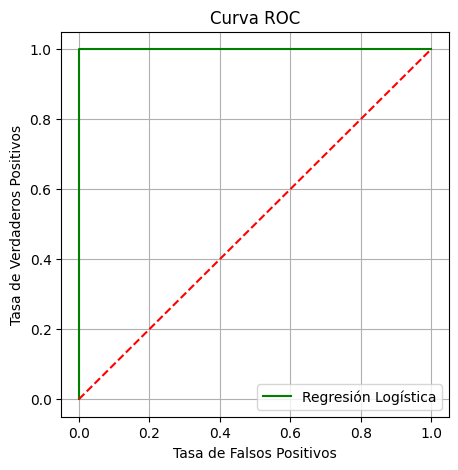

AUC Regresión Logística = 1.0

Datos escalados con RobustScaler


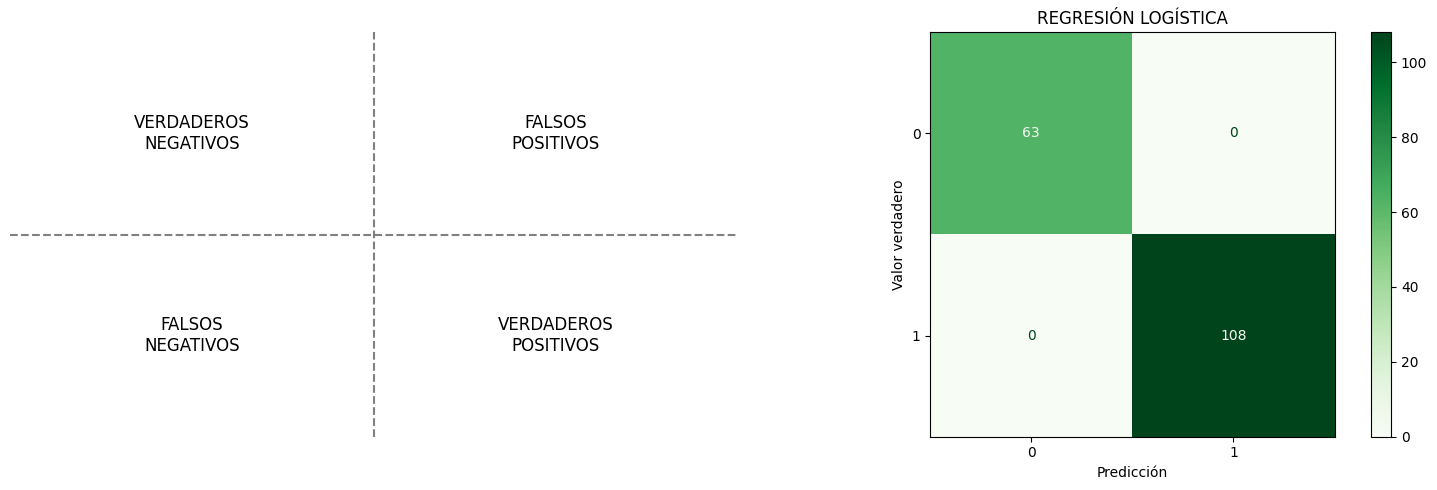

REGRESION LOGISTICA
Accuracy               100.0%
Precision                 1.0
Recall                    1.0

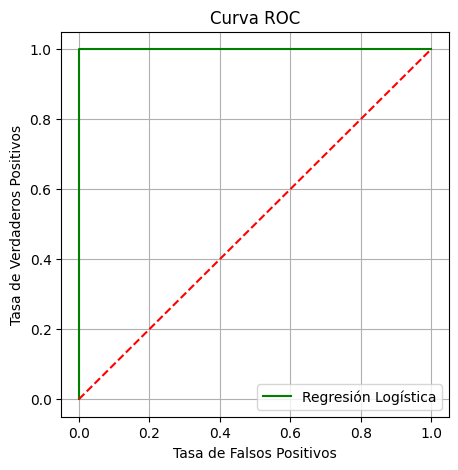

AUC Regresión Logística = 1.0

Datos escalados con Normalizer


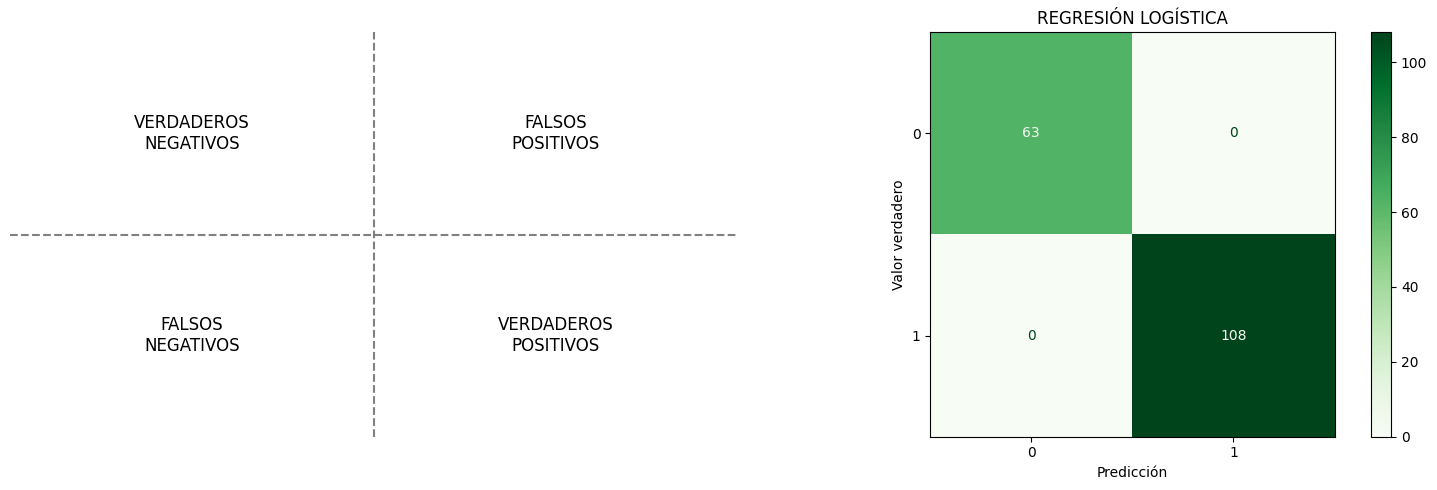

REGRESION LOGISTICA
Accuracy               100.0%
Precision                 1.0
Recall                    1.0

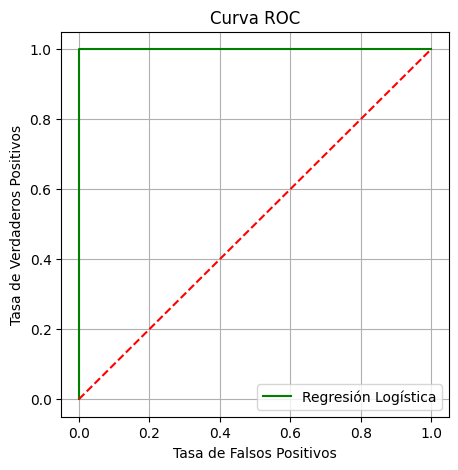

AUC Regresión Logística = 1.0


In [51]:
for i in scaled_df:
    print (f"\nDatos escalados con {i}")
    
    X_train_SS = scaled_df[i][0]
    X_test_SS = scaled_df[i][1]

    LogRegression (X_train_SS, y_train, X_test_SS, y_test)

En la siguiente tabla, se resume el desempeño del modelo con el conjunto de prueba:

|Modelo             |Características|Método de selección|Método de escalado|Precisión|Recall|AUC   |
|-------------------|---------------|-------------------|------------------|---------|------|------|
|Regresión Logística|Todas  	    |Sin selección  	|Sin escalado      |  0,96   | 0,98 | 1,00 |
|Regresión Logística|Todas  	    |Sin selección  	|StandardScaler    |1,00     | 1,00 | 1,00 |
|Regresión Logística|Todas  	    |Sin selección  	|MinMaxScaler      |1,00     |1,00  | 1,00 |
|Regresión Logística|Todas  	    |Sin selección  	|RobustScaler      |1,00     |1,00  | 1,00 |
|Regresión Logística|Todas  	    |Sin selección  	|Normalizer        |1,00     |1,00  | 1,00 |


Observaciones: Al igual que el caso anterior las métricas mostraron muy buenos resultados. Además, hubo grandes diferencias al escalar los datos.

Regresión Logística con features seleccionadas

In [52]:
selected_columns = list(selected_features)
selected_columns.append('target')
print(selected_columns)


['mean texture', 'mean concave points', 'area error', 'concave points error', 'worst radius', 'worst texture', 'worst area', 'worst smoothness', 'target']


In [53]:
df_selected = df[selected_columns]
df_selected.head()

mean texture  mean concave points  area error  concave points error  \
0         10.38              0.14710      153.40               0.01587   
1         17.77              0.07017       74.08               0.01340   
2         21.25              0.12790       94.03               0.02058   
3         20.38              0.10520       27.23               0.01867   
4         14.34              0.10430       94.44               0.01885   

   worst radius  worst texture  worst area  worst smoothness  target  
0         25.38          17.33      2019.0            0.1622       0  
1         24.99          23.41      1956.0            0.1238       0  
2         23.57          25.53      1709.0            0.1444       0  
3         14.91          26.50       567.7            0.2098       0  
4         22.54          16.67      1575.0            0.1374       0

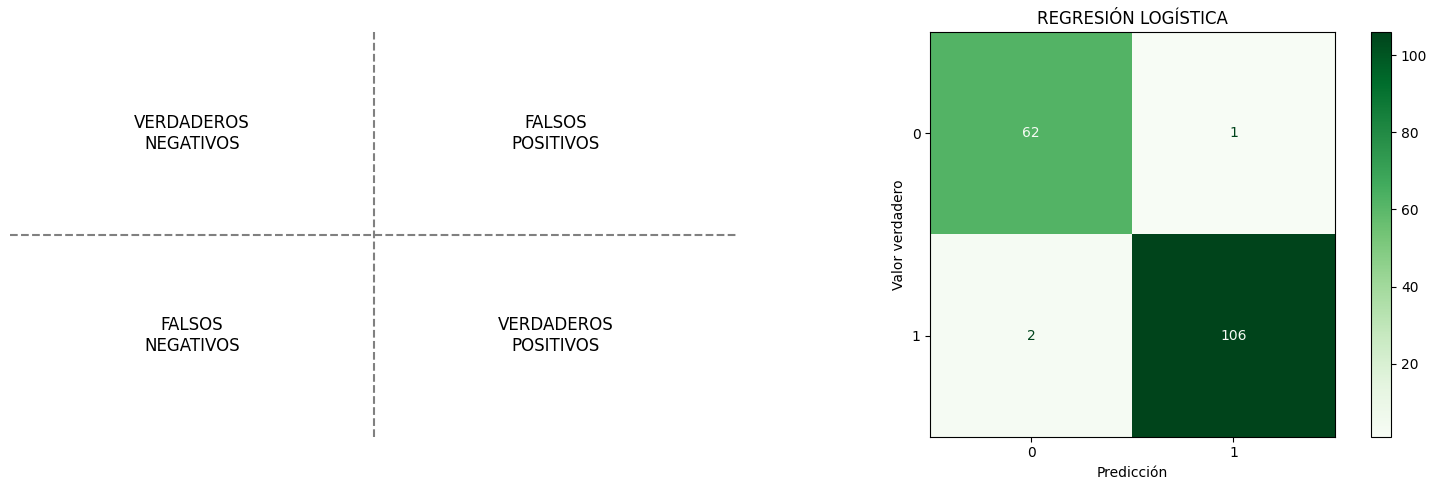

REGRESION LOGISTICA
Accuracy               98.25%
Precision              0.9907
Recall                 0.9815

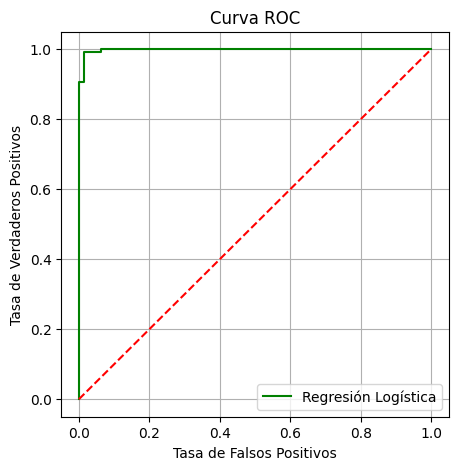

AUC Regresión Logística = 0.9980893592004703


In [54]:
X = df.drop('target', axis=1)
y = df['target']
# 70-30
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42)

# Escalamiento de datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

LogRegression (X_train_scaled, y_train, X_test_scaled, y_test)

Utilizando este método, las métricas resultaron:

|Modelo             |Características|Método de selección|Método de escalado|Precisión|Recall|AUC |
|-------------------|---------------|-------------------|------------------|---------|------|----|
|Regresión Logística|	    8 	    |Forward            |MinMaxScaler      |   0,99  | 0,98 |1,00|


Observaciones: Realizando una selección de características como la utilizada se encuentra un desempeño similar a casos previos.

Además, se experimentó con un modelo SVC usando validación cruzada para ver cambios en el desempeño

In [55]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [56]:
# Crear el modelo
model = SVC(kernel='linear')

# Configurar la validación cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el modelo usando validación cruzada
scores = cross_val_score(model, X_scaled, y, cv=skf)

print(f'Scores: {scores}')
print(f'Average Score: {scores.mean()}')

Scores: [0.99122807 0.94736842 0.95614035 0.99122807 0.99115044]
Average Score: 0.9754230709517155


Considerando el modelo dado por la siguiente tabla:

|Modelo|Características|Método de selección|Método de escalado|Nº de Folds CV|
|------|---------------|-------------------|------------------|--------------|
|SVC   |Todas          |Sin selección      |StandardScaler    |       5      |

Se encontraron los siguientes resultados:

|Nº de Fold|Precisión|
|----------|---------|
|1         |  0,99   |
|2         |  0,95   |
|3         |  0,96   |
|4         |  0,99   |
|5         |  0,99   |

Siendo sus estadísticos:

|Estadístico|Valor|
|-----------|-----|
|Media      |0,98 |
|STD        |0,02 |

Observaciones: Aplicando *Validación Cruzada* hubo poca varaibilidad en la precisión y su valor medio mostró muy buen desempeño.

Por otro lado, se usó la técnica "Recursive feature elimination" para ver cambios en las métricas.

In [57]:
# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

feature_names = X.columns

model = LogisticRegression(max_iter=10000)  # Sí o sí el modelo converge

for i in range(1, 32):
    rfe = RFE(estimator=model, n_features_to_select=i)

    rfe.fit(X_train_scaled, y_train)

    X_train_selected = rfe.transform(X_train_scaled)
    X_test_selected = rfe.transform(X_test_scaled)

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)

    print(f'\nNúmero de características seleccionadas: {rfe.n_features_}')
    print(f'Características seleccionadas: {feature_names[rfe.support_]}')
    print(f'Precisión del modelo: {accuracy:.2f}')


Número de características seleccionadas: 1
Características seleccionadas: Index(['worst area'], dtype='object')
Precisión del modelo: 0.95

Número de características seleccionadas: 2
Características seleccionadas: Index(['worst area', 'worst concave points'], dtype='object')
Precisión del modelo: 0.96

Número de características seleccionadas: 3
Características seleccionadas: Index(['worst radius', 'worst area', 'worst concave points'], dtype='object')
Precisión del modelo: 0.96

Número de características seleccionadas: 4
Características seleccionadas: Index(['radius error', 'worst radius', 'worst area', 'worst concave points'], dtype='object')
Precisión del modelo: 0.95

Número de características seleccionadas: 5
Características seleccionadas: Index(['radius error', 'worst radius', 'worst texture', 'worst area',
       'worst concave points'],
      dtype='object')
Precisión del modelo: 0.97

Número de características seleccionadas: 6
Características seleccionadas: Index(['mean concav

c:\Users\SHIFTA-0164\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=31 > n_features=30. There will be no feature selection and all features will be kept.
  warnings.warn(


Los resultados con esta técnica se muestran en la siguiete tabla:

|Modelo             |Características|Método de selección|Método de escalado|Precisión|
|-------------------|---------------|-------------------|------------------|---------|
|Regresión Logística|       1       |Forward            |StandardScaler    |   0,95  |
|Regresión Logística|       2       |Forward            |StandardScaler    |   0,96  |
|Regresión Logística|       3       |Forward            |StandardScaler    |   0,96  |
|Regresión Logística|       4       |Forward            |StandardScaler    |   0,95  |
|Regresión Logística|       5       |Forward            |StandardScaler    |   0,97  |
|Regresión Logística|       6       |Forward            |StandardScaler    |   0,98  |

Observaciones: Poca variación al considerar diferente cantidad de características seleccionadas con este método.

Por otro lado, se utilizó una selección Backward de las características y en diferentes modelos de clasificación para evaluar el desempeño con esta técnica.

In [58]:
# Reemplaza 0 con 'maligno' y 1 con 'benigno'
df_aux = df.copy()
df_aux['target'] = df['target'].replace({0: 'maligno', 1: 'benigno'})

In [59]:
# Importa las clases necesarias
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [60]:
# Divide en variables independientes (X) y dependientes (y)
X = df_aux.drop('target', axis=1)
y = df_aux['target']

In [61]:
# Establece el modelo de base
model = LogisticRegression(solver='liblinear')

In [62]:
# Aplica RFE para seleccion de caracteristicas (implementa el método wrapper backward eliminando las características menos importantes)
rfe = RFE(model, n_features_to_select=5)
fit = rfe.fit(X, y)

In [63]:
# Evalua las caracteristicas seleccionadas
selected_features = X.columns[fit.support_]
print(f"Selected Features: {selected_features.tolist()}")

Selected Features: ['mean radius', 'mean concavity', 'worst radius', 'worst concavity', 'worst concave points']


In [64]:
# Para ver el ranking de todas las características
ranking = fit.ranking_
print(f"Feature Ranking: {dict(zip(X.columns, ranking))}")

Feature Ranking: {'mean radius': 1, 'mean texture': 10, 'mean perimeter': 12, 'mean area': 26, 'mean smoothness': 13, 'mean compactness': 17, 'mean concavity': 1, 'mean concave points': 2, 'mean symmetry': 7, 'mean fractal dimension': 21, 'radius error': 23, 'texture error': 8, 'perimeter error': 3, 'area error': 6, 'smoothness error': 22, 'compactness error': 24, 'concavity error': 14, 'concave points error': 19, 'symmetry error': 18, 'fractal dimension error': 25, 'worst radius': 1, 'worst texture': 9, 'worst perimeter': 4, 'worst area': 20, 'worst smoothness': 15, 'worst compactness': 5, 'worst concavity': 1, 'worst concave points': 1, 'worst symmetry': 16, 'worst fractal dimension': 11}


A continuación, se implementan 4 modelos con búsqueda de hiperparámetros por grilla, se decidió aplicar y comparar los resultados de los siguientes modelos:

Regresión Logística.

SVC.

Árbol de Clasificación.

Perceptrón.

Ensamble Boosting

In [65]:
# Importa split de datos, busqueda de hiper-parametros, estandarizacion y metricas
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [66]:
# Separa las caracteristicas y el objetivo
X = df_aux.loc[:, ['mean radius', 'mean concavity', 'worst radius', 'worst concavity', 'worst concave points']].values
y = df_aux.loc[:, "target"].values

In [67]:
# Divide los datos en conjunto de entrenamiento y prueba 80/20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Regresión Logística

Mejores hiperparámetros: LogisticRegression(C=100, max_iter=1000)
Precision: 0.9767441860465116
Recall: 0.9767441860465116
F1 Score: 0.9767441860465116


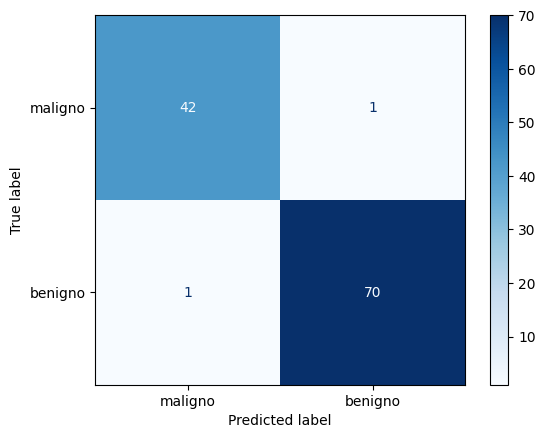

In [68]:
# Importa el algoritmo
from sklearn.linear_model import LogisticRegression

# Define la grilla de hiper-parametros
param_grid = {
    'C': [0.1, 1, 10, 100],  # Hiperparámetro para la regularización
    'solver': ['liblinear', 'lbfgs']  # Solvers para la optimización
}

# Asigna el modelo
model = LogisticRegression(max_iter=1000)

# Configura la busqueda de hiper-parametros por grilla con validacion cruzada
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Entrena el modelo
grid_search.fit(X_train, y_train)

# Obtiene el mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores hiperparámetros: {best_model}")

# Obtiene las predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcula metricas
precision = precision_score(y_test, y_pred, pos_label='maligno')
recall = recall_score(y_test, y_pred, pos_label='maligno')
f1 = f1_score(y_test, y_pred, pos_label='maligno')
conf_matrix = confusion_matrix(y_test, y_pred, labels=['maligno', 'benigno'])

# Muestra metricas
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Muestra matriz de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['maligno', 'benigno'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

SVC

Mejores hiperparámetros: SVC(C=0.1, gamma='auto', kernel='poly')
Precision: 0.9767441860465116
Recall: 0.9767441860465116
F1 Score: 0.9767441860465116


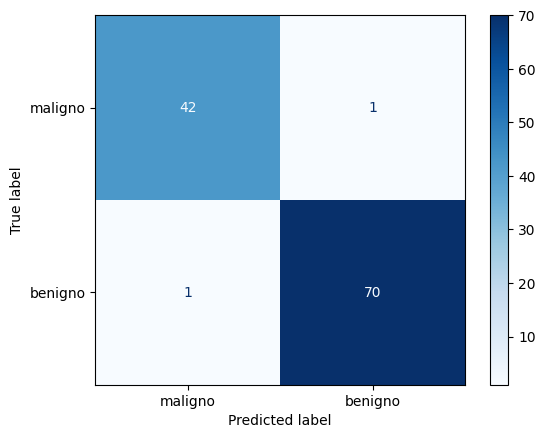

In [69]:
# Importa el algoritmo
from sklearn.svm import SVC

# Define la grilla de hiperparametros
param_grid = {
    'C': [0.1, 1, 10, 100],  # Hiperparámetro para la regularización
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Tipos de núcleos
    'gamma': ['scale', 'auto']  # Parámetro del núcleo
}

# Support Vector Classifier
model = SVC()

# Define la grilla de hiper-parametros
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy') 

# Entrena el modelo
grid_search.fit(X_train,y_train)

# Obtiene los mejores hiper-parametros
best_model = grid_search.best_estimator_
print(f"Mejores hiperparámetros: {best_model}")

# Obtiene las predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcula metricas
precision = precision_score(y_test, y_pred, pos_label='maligno')
recall = recall_score(y_test, y_pred, pos_label='maligno')
f1 = f1_score(y_test, y_pred, pos_label='maligno')
conf_matrix = confusion_matrix(y_test, y_pred, labels=['maligno', 'benigno'])

# Muestra metricas
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Muestra matriz de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['maligno', 'benigno'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Árbol de Clasificación

Mejores hiperparámetros: DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=5)
Precision: 0.926829268292683
Recall: 0.8837209302325582
F1 Score: 0.9047619047619048


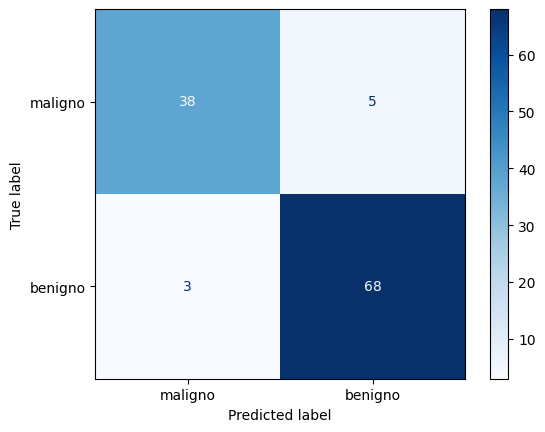

In [70]:
# Importa el algoritmo
from sklearn.tree import DecisionTreeClassifier

# Crea el modelo de arbol de clasificacion
model = DecisionTreeClassifier()

# Define la grilla de hiper-parametros
param_grid = {
    'criterion': ['gini', 'entropy'],  # Funcion para medir la calidad de una division
    'max_depth': [None, 10, 20, 30],   # Profundidad máxima del arbol
    'min_samples_split': [2, 5, 10],   # Numero minimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4]      # Numero minimo de muestras requeridas para estar en una hoja
}

# Configura GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Entrena el modelo
grid_search.fit(X_train, y_train)

# Obtiene los mejores hiper-parametros
best_model = grid_search.best_estimator_
print(f"Mejores hiperparámetros: {best_model}")

# Obtiene las predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcula metricas
precision = precision_score(y_test, y_pred, pos_label='maligno')
recall = recall_score(y_test, y_pred, pos_label='maligno')
f1 = f1_score(y_test, y_pred, pos_label='maligno')
conf_matrix = confusion_matrix(y_test, y_pred, labels=['maligno', 'benigno'])

# Muestra metricas
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Muestra matriz de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['maligno', 'benigno'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Perceptrón

Mejores hiperparámetros: Perceptron(eta0=0.1, penalty='elasticnet')
Precision: 0.5584415584415584
Recall: 1.0
F1 Score: 0.7166666666666667


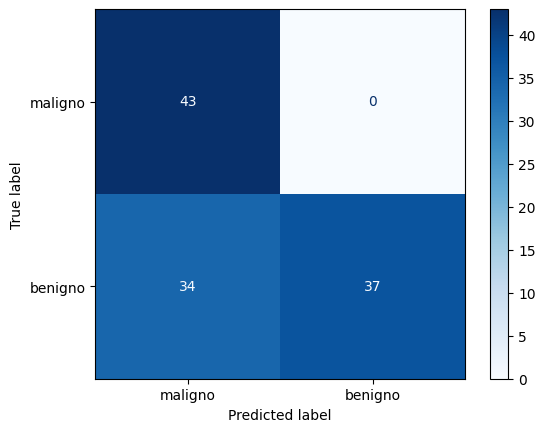

In [71]:
# Importa el algoritmo
from sklearn.linear_model import Perceptron

# Crea el modelo de perceptron
model = Perceptron()

# Define la grilla de hiper-parametros
param_grid = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],  # Tipo de regularizacion
    'alpha': [0.0001, 0.001, 0.01],  # Parametro de regularizacion
    'max_iter': [1000, 5000, 10000],  # Numero maximo de iteraciones
    'eta0': [1.0, 0.1, 0.01]  # Tasa de aprendizaje inicial
}

# Realiza la busqueda de hiperparametros con GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Entrena el modelo
grid_search.fit(X_train, y_train)

# Obtiene los mejores hiperparametros
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros:", best_model)

# Obtiene las predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcula metricas
precision = precision_score(y_test, y_pred, pos_label='maligno')
recall = recall_score(y_test, y_pred, pos_label='maligno')
f1 = f1_score(y_test, y_pred, pos_label='maligno')
conf_matrix = confusion_matrix(y_test, y_pred, labels=['maligno', 'benigno'])

# Muestra metricas
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Muestra matriz de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['maligno', 'benigno'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Ensamble por Bagging

c:\Users\SHIFTA-0164\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Mejores hiperparámetros encontrados: {'n_estimators': 50, 'max_samples': 0.7, 'max_features': 0.7, 'estimator': LogisticRegression(), 'bootstrap_features': False, 'bootstrap': True}
Precision: 1.0
Recall: 0.8837209302325582
F1-score: 0.9382716049382716


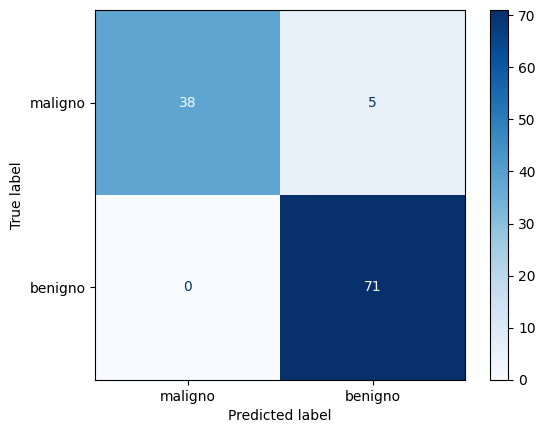

In [72]:
# Importa la busqueda aleatoria de hiperparametros
from sklearn.model_selection import train_test_split, RandomizedSearchCV
# Importa el algoritmo
from sklearn.ensemble import BaggingClassifier

# Define los modelos base
base_estimators = [
    DecisionTreeClassifier(),
    SVC(probability=True),
    LogisticRegression(),
    Perceptron()
]

# Define el clasificador de Bagging
bagging = BaggingClassifier(random_state=42)

# Define el espacio de hiperparametros para la busqueda aleatoria
param_distributions = {
    'estimator': base_estimators,
    'n_estimators': [10, 20, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

# Configura la busqueda aleatoria
random_search = RandomizedSearchCV(bagging, param_distributions, n_iter=50, scoring='f1', cv=5, random_state=42, n_jobs=-1)

# Ajusta el modelo
random_search.fit(X_train, y_train)

# Predece con el mejor modelo encontrado
y_pred = random_search.best_estimator_.predict(X_test)

# Calcula las metricas
precision = precision_score(y_test, y_pred, pos_label="maligno")
recall = recall_score(y_test, y_pred, pos_label="maligno")
f1 = f1_score(y_test, y_pred, pos_label="maligno")
conf_matrix = confusion_matrix(y_test, y_pred, labels=["maligno", "benigno"])

# Muestra los resultados
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Muestra matriz de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["maligno", "benigno"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Ensamble  por Boosting.

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Precision: 0.9473684210526315
Recall: 0.8571428571428571
F1 Score: 0.9


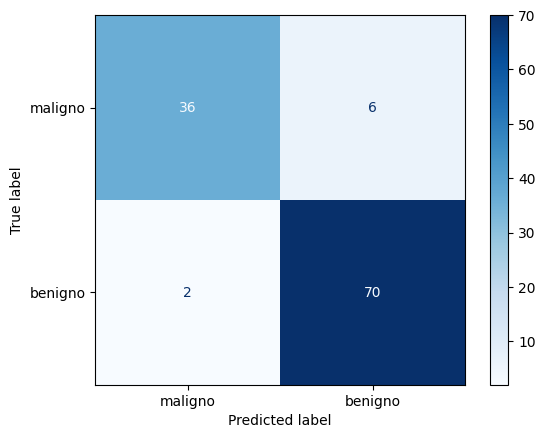

In [73]:
# Importa el algoritmo
from xgboost import XGBClassifier

X_aux = df.loc[:, ['mean radius', 'mean concavity', 'worst radius', 'worst concavity', 'worst concave points']].values
y_aux = df['target']

# Divide el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_aux, y_aux, test_size=0.2, random_state=42, stratify=y)

# Crea el ensamble
model = XGBClassifier()

# Define la grilla de hiper-parametros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Realiza la busqueda de hiperparametros con GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# Entrena el modelo
grid_search.fit(X_train, y_train)

# Obtiene los mejores hiperparametros
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros:", best_model)

# Obtiene las predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcula metricas
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred, pos_label=0)
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Muestra metricas
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Muestra matriz de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['maligno', 'benigno'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Se realizó una tabla comparativa de los resultados de las métricas sobre el conjunto datos de prueba:

| Modelo                 |Características|Método de selección|Método de escalado|Bus. Hiper.|Presición|Recall|F1-Score|
|------------------------|---------------|-------------------|------------------|-----------|---------|------|--------|
| Regresión Logistica    |5              |Backward           |Sin escalar       |Grilla     |  0,98   | 0,98 |  0,98  |
| SVC                    |5              |Backward           |Sin escalar       |Grilla     |  0,98   | 0,98 |  0,98  |
| Árbol de Clasificación |5              |Backward           |Sin escalar       |Grilla     |  0,93   | 0,88 |  0,91  |
| Perceptrón             |5              |Backward           |Sin escalar       |Grilla     |  0,56   | 1,00 |  0,72  |
| Ensamble Bagging       |5              |Backward           |Sin escalar       |Aleatoria  |  1,00   | 0,88 |  0,94  |
| Ensamble Boosting      |5              |Backward           |Sin escalar       |Grilla     |  0,98   | 0,93 |  0,95  |

Conclusiones: En general las métricas arrojan una buena performance de los cuatro modelos. El que menos performance muestra es el perceptrón. No obstante, la precisión de 0.97 se supera con el conjunto completo de características como se muestra en https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic utilizando Random Forest con un valor de 0.98 de valor medio de precisión como se muestra en la siguiente figura:

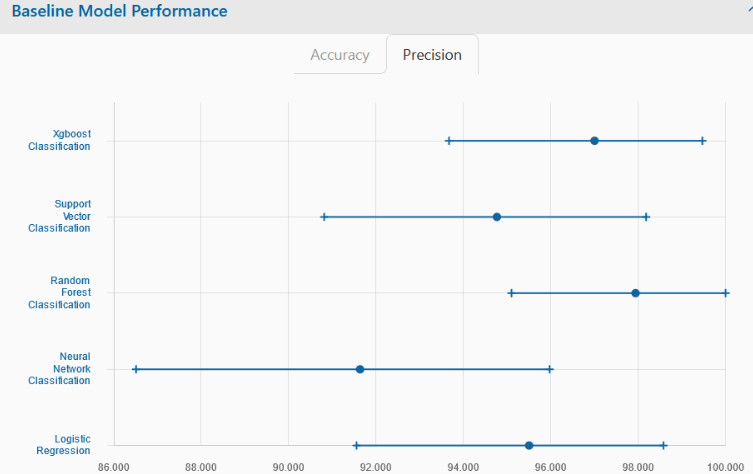

No obstante, obtener desempeños similares con una cantidad inferior de características es un buen resultado de por si.

Por otro lado, fue interés del equipo conocer como varía la precisión del modelo con diferentes tamaños de muestra. Para eso, se analizó la curva de aprendizaje para ver cómo el tamaño del conjunto de entrenamiento afecta la precisión del modelo.

In [74]:
# Importa las clases necesarias
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

In [75]:
# Genera la curva de aprendizaje con validacion cruzada de 5 folds
train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(max_iter=1000), X_train, y_train, cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

In [76]:
# Calcula las medias y desviaciones estandar para las precisiones
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

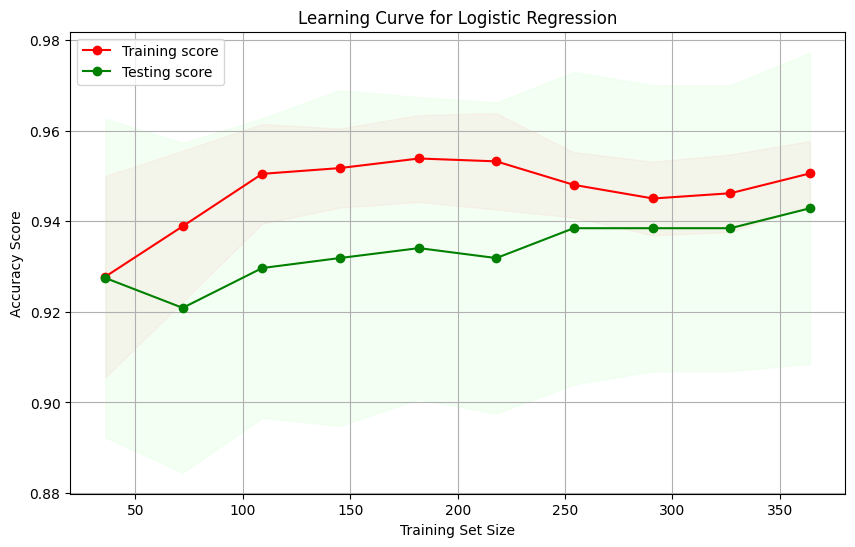

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Testing score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#FF9999", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#99FF99", alpha=0.1)

plt.title("Learning Curve for Logistic Regression")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid()
plt.show()

Observaciones: Este gráfico muestra como la precisión del modelo varía según el tamaño del conjunto de entrenamiento.

En tamaños pequeños de entrenamiento, como la precisión media de entrenamiento es alta pero la de evaluación es baja, el modelo podría estar sobreajustando para esos casos.
Se observó cierta convergencia, es decir las curvas medias de entrenamiento y evaluación se acercan a medida que aumenta el tamaño del conjunto de entrenamiento, el modelo generaliza.

Por otro lado, hay una disminución progresiva del desvío estándar de la precisión del conjunto de prueba, esto se debe a que cada una de las evaluaciones en los folds de la validación cruzada ve performance diferentes que al aumentar el tamaño de la muestra convergen. Esto apoya la idea de que el modelo adopta la capacidad de generalizar independientemente del conjunto de datos.

### T-SNE

Aplicamos reducción de dimensionalidad (2 y 3 dimensiones)con t-sne para verificar visualmente una clara clasificación de los datos

In [78]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [89]:
# Definir colores
palette = {
    'maligno': '#ff9999',  # Rojo
    'benigno': '#99ff99'   # Verde
}

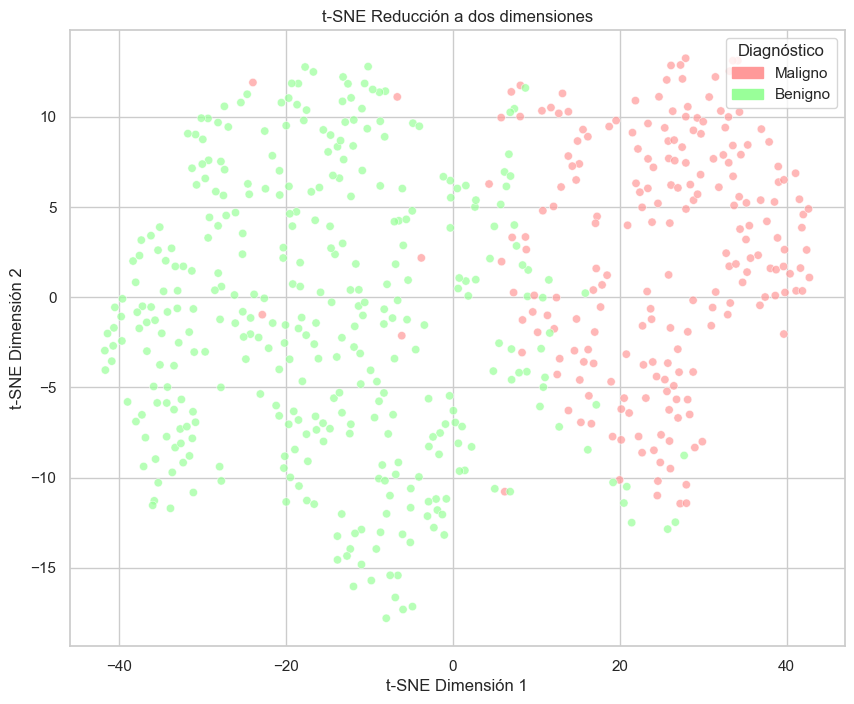

In [93]:
# Configurar y ajustar t-SNE para dos dimensiones
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

df_tsne = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['target'] = y

sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='target', data=df_tsne, palette=palette, alpha=0.7)
plt.title('t-SNE Reducción a dos dimensiones')
plt.xlabel('t-SNE Dimensión 1')
plt.ylabel('t-SNE Dimensión 2')
handles = [patches.Patch(color=palette['maligno'], label='Maligno'), patches.Patch(color=palette['benigno'], label='Benigno')]
plt.legend(handles=handles, title='Diagnóstico', loc='upper right')
plt.show()

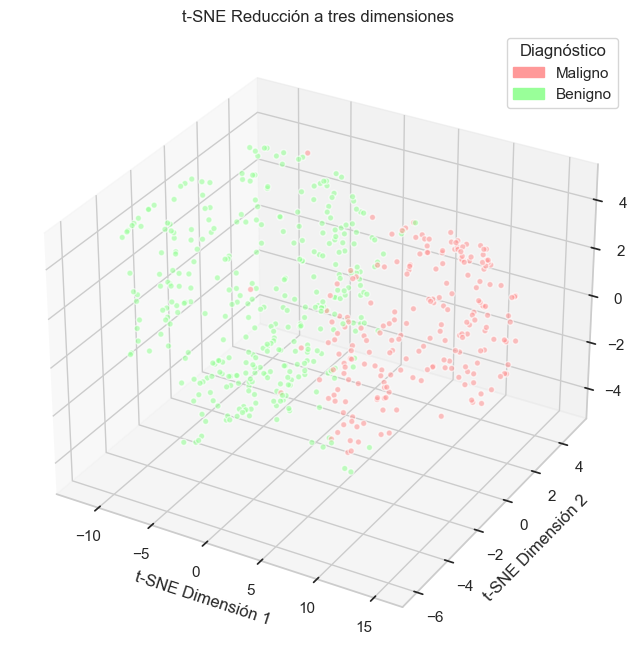

In [94]:
# Aplicar t-SNE para reducción a tres dimensiones
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

df_tsne = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2', 'TSNE3'])
df_tsne['target'] = y

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


colors = [palette[label] for label in df_tsne['target']]
 
ax.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], df_tsne['TSNE3'], c=colors, alpha=0.6, edgecolors='w')

# Etiquetas y título
ax.set_xlabel('t-SNE Dimensión 1')
ax.set_ylabel('t-SNE Dimensión 2')
ax.set_zlabel('t-SNE Dimensión 3')
ax.set_title('t-SNE Reducción a tres dimensiones')
handles = [patches.Patch(color=palette['maligno'], label='Maligno'), patches.Patch(color=palette['benigno'], label='Benigno')]
plt.legend(handles=handles, title='Diagnóstico', loc='best')

plt.show()


### Conclusiones generales

El conjunto de datos presentado en el repositorio de UCI dataset se encuentra fuertemente procesado. Es decir, en el análisis propuesto en este trabajo se pudo constatar la ausencia de datos faltantes ni registros repetidos. Además se pudo verificar que los tipos de datos se encuentran unificados y sin inconsistencias.

Por otro lado, al estudiar la distribución de las características para ambas clases (tumor maligno/benigno), se observó que si bien en algunas características es posible discernir rangos de dominio en los que se pueden diferenciar ambas clases, en otras resulta más difícil dado que la distribución de ambas clases se superponen. Por otro lado, en todos los casos se pudo apreciar que la distribución de las características en el caso benigno tienen menos dispersión y máximos mayores que en el caso maligno. En cuanto a la variable objetivo, se pudo ver que tiene una baja cardinalidad (binaria) y no se encuentra balanceada.

También se encontró una elevada correlación lineal entre algunas características. Como es el caso de las variables medias y en su peor versión, como es el caso de radius mean y radius worst a modo de ejemplo. Además se verificaron dependencia esperables entre características como por ejemplo el radio y el perímetro o entre el radio y el área (lineal y cuadrática respectivamente). Esto sugirió realizar experimentos de evaluación de desempeño de modelos de aprendizaje con un subconjunto de características.

En cuanto a los outliers se pudo identificar que todas las características presentan valores por encima de los tres desvíos estándar. Si bien se consideró inicialmente aplicar alguna técnica sobre ellos, los resultados de desempeño de modelos de predicción sugirió que no se trataban de errores, o al menos no tenía un impacto sobre este.

Se aplicaron diferentes técnicas de selección de variables, como por ejemplo selección por árbol de clasificación, forward y backward. Luego, para estas técnicas, se evaluaron diferentes modelos como regresión logística, árboles, svc, perceptrón y Ensamble por Boosting. Además, se variaron o combinaron técnicas usando validación cruzada, búsqueda de hiperparámetros por grilla y diferentes métodos de escalado. En todos los casos se pudo apreciar una precisión similar a la indicada por UCI para el dataset (salvo en el caso del perceptrón), lo que invita a pensar que al aplicar estas técnicas solo se mejora el hecho de manipular menos cantidad de características pero no de desempeño del modelo. También cabe destacar que en todos los modelos la cantidad de veces que se predijo un diagnóstico benigno que en realidad era maligno (tal vez el peor escenario en una situación de paciente real) fue extremadamente bajo.

Relativo a los casos cercanos a la frontera de decisión entre tumor maligno y benigno para las características seleccionadas, se vio que los casos extremos son donde se aprecian las mayores diferencias entre clases.

Además, se pudo constatar a partir de la curva de aprendizaje que para tamaños de conjunto de entrenamiento del orden de 350 el 'accuracy' de ambos conjunto converge (también se aprecia una reducción de la varianza de la métrica), lo que es un buen indicador de que el modelo generaliza.

Por último, a partir de la reducción con t-SNE se pudo comprobar visualmente que el conjunto de datos provisto tiene una buena separación de clases, salvo algunos casos aislados.

Bibliografía:

Isabelle Guyon, Andre Elisseeff (2003). An introduction to variable and feature selection. Journal of Machine Learning Research 3 (2003) 1157-1182


Wolberg,William, Mangasarian,Olvi, Street,Nick, and Street,W.. (1995). Breast Cancer Wisconsin (Diagnostic). UCI Machine Learning Repository. https://doi.org/10.24432/C5DW2B.


W. Street, W. Wolberg, O. Mangasarian. (1992)
Nuclear feature extraction for breast tumor diagnosis.
Published in Electronic imaging.